In [1]:
import numpy as np
from scipy.optimize import fsolve

# Define the system of equations
def equations(vars):
    x, y = vars

    # Equation for x
    eq1 = (3 * np.exp(-x**2 - (y - 1/3)**2) * (-2 * x)
           - 3 * np.exp(-x**2 - (y - 5/3)**2) * (-2 * x)
           - 5 * np.exp(-(x - 1)**2 - y**2) * (-2 * (x - 1))
           - 5 * np.exp(-(x + 1)**2 - y**2) * (-2 * (x + 1))
           + 0.8 * x**3)

    # Equation for y
    eq2 = (3 * np.exp(-x**2 - (y - 1/3)**2) * (-2 * (y - 1/3))
           - 3 * np.exp(-x**2 - (y - 5/3)**2) * (-2 * (y - 5/3))
           - 5 * np.exp(-(x - 1)**2 - y**2) * (-2 * y)
           - 5 * np.exp(-(x + 1)**2 - y**2) * (-2 * y)
           + 0.8 * (y - 1/3)**3)

    return [eq1, eq2]

# Initial guess
initial_guess = [0.11, 0.7]

# Solve the system
solution = fsolve(equations, initial_guess)
print(solution)


[-3.63228730e-16  5.19186742e-01]


In [2]:
def partial_derivative(x,y):
    # Equation for x
    eq1 = (3 * np.exp(-x**2 - (y - 1/3)**2) * (-2 * x)
           - 3 * np.exp(-x**2 - (y - 5/3)**2) * (-2 * x)
           - 5 * np.exp(-(x - 1)**2 - y**2) * (-2 * (x - 1))
           - 5 * np.exp(-(x + 1)**2 - y**2) * (-2 * (x + 1))
           + 0.8 * x**3)

    # Equation for y
    eq2 = (3 * np.exp(-x**2 - (y - 1/3)**2) * (-2 * (y - 1/3))
           - 3 * np.exp(-x**2 - (y - 5/3)**2) * (-2 * (y - 5/3))
           - 5 * np.exp(-(x - 1)**2 - y**2) * (-2 * y)
           - 5 * np.exp(-(x + 1)**2 - y**2) * (-2 * y)
           + 0.8 * (y - 1/3)**3)
    return eq1, eq2

In [3]:
partial_derivative(-1.4, 0)


(-4.694186278547148, 0.13488080673830088)

In [4]:
partial_derivative(0, 0.51919)


(0.0, -1.7430432282983417e-05)

In [5]:
partial_derivative(1.04805, -0.04209)


(-7.019469500113562e-05, 3.6251447541532644e-05)

In [6]:
partial_derivative(-1.04805, -0.04209)


(7.01946950010246e-05, 3.625144754155346e-05)

In [7]:
partial_derivative(0, 1.53708)


(0.0, -1.8585934958181838e-05)

In [8]:
partial_derivative(0, 0.5)


(0.0, 0.10151689838437078)

In [9]:
partial_derivative(0.61727, 1.10273)


(-2.9944356901456803e-05, -8.207557027406498e-06)

In [10]:
partial_derivative(-0.61227, 1.10273)

(0.009819491013362297, -0.028102911678717535)

In [11]:
partial_derivative(0, -0.31582)

(0.0, 3.219475099100477e-05)

In [2]:
import numpy as np
import math
import pandas as pd

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim

from scipy.integrate import solve_ivp

from torchmetrics import Accuracy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

from lion_pytorch import Lion

from tqdm import tqdm

from copy import deepcopy

import warnings
warnings.filterwarnings("ignore")

We consider triple-well potential formulated as shown:
\begin{align*}
V(x,y)=&3e^{-x^{2}-(y-\frac{1}{3})^{2}}-3e^{-x^{2}-(y-\frac{5}{3})^{2}}-5e^{-(x-1)^{2}-y^{2}}\\
    &-5e^{-(x+1)^{2}-y^{2}}+0.2x^{4}+0.2(y-\frac{1}{3})^{4}
\end{align*}

$V$ has local minima at approximately $(-1.04805, -0.04209), (1.04805, -0.04209),$ $ (0, 1.53708)$, local maximum at approximately $(0, 0.51919)$, and saddle points at $(0.61727, 1.10273)$, $(-0.61227, 1.10273)$, and $(0, -0.31582)$

We consider $(0, 0.51919)$ as the attractor.

In [3]:
def system(t, X):
    x, y = X
    xp = (3 * np.exp(-x**2 - (y - 1/3)**2) * (-2 * x)
           - 3 * np.exp(-x**2 - (y - 5/3)**2) * (-2 * x)
           - 5 * np.exp(-(x - 1)**2 - y**2) * (-2 * (x - 1))
           - 5 * np.exp(-(x + 1)**2 - y**2) * (-2 * (x + 1))
           + 0.8 * x**3)
    yp = (3 * np.exp(-x**2 - (y - 1/3)**2) * (-2 * (y - 1/3))
           - 3 * np.exp(-x**2 - (y - 5/3)**2) * (-2 * (y - 5/3))
           - 5 * np.exp(-(x - 1)**2 - y**2) * (-2 * y)
           - 5 * np.exp(-(x + 1)**2 - y**2) * (-2 * y)
           + 0.8 * (y - 1/3)**3)
    return xp, yp

## Bisection method to generate near-boundary points
def bisection(a, b, delta=0.04): ## a has label +1 and b has label -1
    distance = np.linalg.norm(np.array([a[0]-b[0], a[1]-b[1]]))
    if distance < delta:
        return (a, b)
    else:
        c = ((a[0]+b[0])/2, (a[1]+b[1])/2)
        if simulation(c[0], c[1]):
            return bisection(c, b, delta)
        else:
            return bisection(a, c, delta)

def euclidean_distance(point1, point2):
    point1, point2 = np.array(point1), np.array(point2)
    return np.sqrt(np.sum((point1 - point2) ** 2))

attractor = (0, 0.51919)

# Check if the trajectory is attracted to the concerned spiral attractor
def is_attracted(x, y):
    return euclidean_distance((x, y), attractor) < 1e-5

## Implement the simulation process and decide if the trajectory is attracted by the Lorenz attractor
def simulation(x0 ,y0):
    tmax, n = 1500, 100000
    soln = solve_ivp(system, (0, tmax), (x0, y0),dense_output=True, rtol=1e-10, atol=1e-10)
    t = np.linspace(0, tmax, n)
    x, y= soln.sol(t)
    return is_attracted(x[n-1], y[n-1])


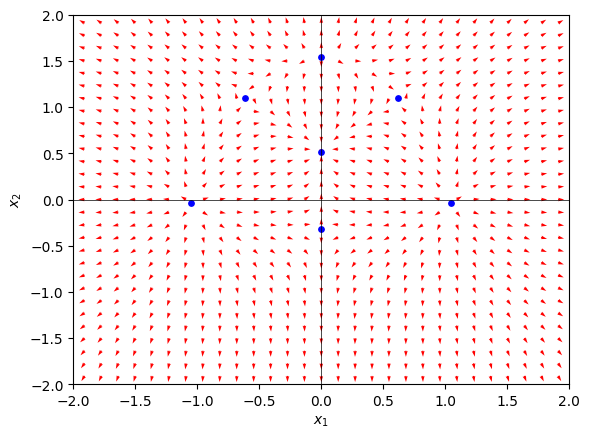

In [4]:
# Define the system of equations
Y, X = np.mgrid[-3:3:45j, -3:3:45j] 
U, V = system(0, (X, Y))

# Normalize arrows
N = np.sqrt(U**2 + V**2)
U = U / N
V = V / N

plt.quiver(X, Y, U, V, color='r')

# Highlight critical points
plt.scatter([-1.04805, 1.04805, 0, 0, 0.61727, -0.61727, 0], [-0.04209, -0.04209, 1.53708, 0.51919, 1.10273, 1.10273, -0.31582], color='blue', s=15) 

# Add axes
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)

plt.xlim([-2, 2])  # x-axis limits include negative values
plt.ylim([-2, 2])  # y-axis limits include negative values
plt.xlabel('$x_{1}$')
plt.ylabel('$x_{2}$')

plt.show()

In [15]:
point = (0.1747122153123808,0.6110848307408023)
soln = solve_ivp(system, (0, 1500), (0.1747122153123808, 0.6110848307408023),dense_output=True, rtol=1e-10, atol=1e-10)
t = np.linspace(0, 1500, 100000)
x, y= soln.sol(t)
print(x[99999], y[99999])
print(is_attracted(x[99999], y[99999]))
result = (x[99999], y[99999])
print(euclidean_distance(result, attractor))
print(attractor)


1.6884143749533722e-11 0.5191867418920727
True
3.2581079273834635e-06
(0, 0.51919)


In [35]:
## Generate 10,000 uniformly sampled points in the square [-2, 2] x [-2, 2]
np.random.seed(0)
X = np.random.uniform(-1.5, 1.5, 10000)
Y = np.random.uniform(-0.5, 2, 10000)

# Create the dataset
df = pd.DataFrame(columns=['x0', 'y0', 'attracted'])
for i in tqdm(range(10000)):  # wrap range with tqdm for progress bar
    x0, y0 = X[i], Y[i]
    attracted_result = simulation(x0, y0)
    attracted_result = 1 if attracted_result else -1  # map True to 1 and False to -1
    df.loc[i] = [x0, y0, attracted_result]

# Save the DataFrame to a CSV file
df.to_csv('dataset_triplewell_general_10000.csv', index=False)


100%|██████████| 10000/10000 [31:49<00:00,  5.24it/s]


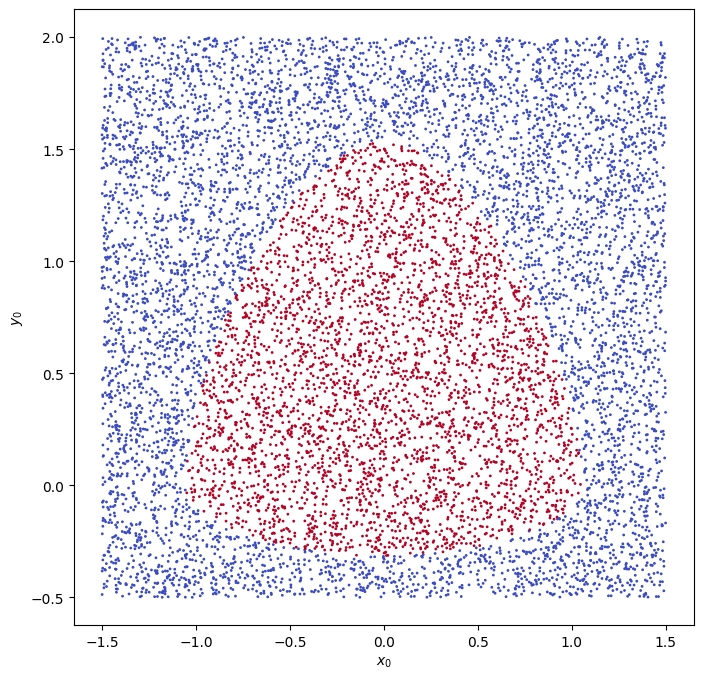

In [16]:
## Plot the sampled datapoints
df = pd.read_csv('dataset_triplewell_general_10000.csv')
plt.figure(figsize=(8, 8))
plt.scatter(df['x0'], df['y0'], c=df['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_0$')
plt.ylabel('$y_0$')
plt.show()

In [37]:
df_data = pd.read_csv('dataset_triplewell_general_10000.csv')

df_data_1 = df_data[df_data['attracted'] == 1].sample(50)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(50)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b, delta=0.01)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_triplewell_near_5000_0.01.csv', index=False)

Processing df_1: 100%|██████████| 50/50 [1:09:06<00:00, 82.93s/it]


In [38]:
df_data = pd.read_csv('dataset_triplewell_general_10000.csv')

df_data_1 = df_data[df_data['attracted'] == 1].sample(50)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(50)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b, delta=0.02)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_triplewell_near_5000_0.02.csv', index=False)

Processing df_1: 100%|██████████| 50/50 [58:55<00:00, 70.71s/it]


In [39]:
df_data = pd.read_csv('dataset_triplewell_general_10000.csv')

df_data_1 = df_data[df_data['attracted'] == 1].sample(50)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(50)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b, delta=0.03)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_triplewell_near_5000_0.03.csv', index=False)

Processing df_1: 100%|██████████| 50/50 [55:52<00:00, 67.05s/it]


In [40]:
df_data = pd.read_csv('dataset_triplewell_general_10000.csv')

df_data_1 = df_data[df_data['attracted'] == 1].sample(50)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(50)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b, delta=0.04)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_triplewell_near_5000_0.04.csv', index=False)

Processing df_1: 100%|██████████| 50/50 [49:39<00:00, 59.59s/it]


In [41]:
df_data = pd.read_csv('dataset_triplewell_general_10000.csv')

df_data_1 = df_data[df_data['attracted'] == 1].sample(50)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(50)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b, delta=0.05)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_triplewell_near_5000_0.05.csv', index=False)

Processing df_1: 100%|██████████| 50/50 [45:27<00:00, 54.55s/it]


In [42]:
df_data = pd.read_csv('dataset_triplewell_general_10000.csv')

df_data_1 = df_data[df_data['attracted'] == 1].sample(50)
df_data_n1 = df_data[df_data['attracted'] == -1].sample(50)

dataset_near = []
for i in tqdm(range(len(df_data_1)), desc="Processing df_1"):
    for j in range(len(df_data_n1)):
        a = (df_data_1.iloc[i]['x0'], df_data_1.iloc[i]['y0'])
        b = (df_data_n1.iloc[j]['x0'], df_data_n1.iloc[j]['y0'])
        a, b = bisection(a, b, delta=0.1)
        dataset_near.append([a[0], a[1], 1])
        dataset_near.append([b[0], b[1], -1])

df_near = pd.DataFrame(dataset_near, columns=['x0', 'y0', 'attracted'])
df_near.to_csv('dataset_triplewell_near_5000_0.1.csv', index=False)

Processing df_1: 100%|██████████| 50/50 [36:11<00:00, 43.43s/it]


In [5]:
class SystemDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.data.iloc[idx, 0:2].values).float()
        y = torch.tensor(self.data.iloc[idx, 2]).float()
        return x, y

In [6]:
'''
dataset_train: uniformly sampled 200 points
dataset_validation_uniform: uniformly sampled 1,000 points
dataset_test_uniform: uniformly sampled 1,000 points
dataset_validation_near: 1,000 points near the boundary
dataset_test_near: 1,000 points near the boundary
Each dataset above are mutually independent
'''

def filter_points_within_bounds(df, x_bounds=(-1.5, 1.5), y_bounds=(-0.5, 2)):
    # Filter the DataFrame to include only points within the specified bounds
    within_bounds = (df['x0'] >= x_bounds[0]) & (df['x0'] <= x_bounds[1]) & \
                    (df['y0'] >= y_bounds[0]) & (df['y0'] <= y_bounds[1])
    filtered_df = df[within_bounds]
    return filtered_df




df_uniform = pd.read_csv('dataset_triplewell_general_10000.csv')
df_uniform = filter_points_within_bounds(df_uniform)
df_uniform_train = df_uniform.sample(n=200)
remaining_df = df_uniform.drop(df_uniform_train.index)
df_uniform_validation = remaining_df.sample(n=1000)
remaining_df = remaining_df.drop(df_uniform_validation.index)
df_uniform_test = remaining_df.sample(n=1000)

df_001 = pd.read_csv('dataset_triplewell_near_5000_0.01.csv')
df_001 = filter_points_within_bounds(df_001)
df_001_validation = df_001.sample(n=1000)
remaining_df = df_001.drop(df_001_validation.index)
df_001_test = remaining_df.sample(n=1000)

df_002 = pd.read_csv('dataset_triplewell_near_5000_0.02.csv')
df_002 = filter_points_within_bounds(df_002)
df_002_validation = df_002.sample(n=1000)
remaining_df = df_002.drop(df_002_validation.index)
df_002_test = remaining_df.sample(n=1000)

df_003 = pd.read_csv('dataset_triplewell_near_5000_0.03.csv')
df_003 = filter_points_within_bounds(df_003)
df_003_validation = df_003.sample(n=1000)
remaining_df = df_003.drop(df_003_validation.index)
df_003_test = remaining_df.sample(n=1000)

df_004 = pd.read_csv('dataset_triplewell_near_5000_0.04.csv')
df_004 = filter_points_within_bounds(df_004)
df_004_validation = df_004.sample(n=1000)
remaining_df = df_004.drop(df_004_validation.index)
df_004_test = remaining_df.sample(n=1000)

df_005 = pd.read_csv('dataset_triplewell_near_5000_0.05.csv')
df_005 = filter_points_within_bounds(df_005)
df_005_validation = df_005.sample(n=1000)
remaining_df = df_005.drop(df_005_validation.index)
df_005_test = remaining_df.sample(n=1000)

df_010 = pd.read_csv('dataset_triplewell_near_5000_0.1.csv')
df_010 = filter_points_within_bounds(df_010)
df_010_validation = df_010.sample(n=1000)
remaining_df = df_010.drop(df_010_validation.index)
df_010_test = remaining_df.sample(n=1000)


dataset_train = SystemDataset('dataset_triplewell_general_10000.csv')
dataset_train.data = df_uniform_train

dataset_validation_uniform = SystemDataset('dataset_triplewell_general_10000.csv')
dataset_validation_uniform.data = df_uniform_validation

dataset_test_uniform = SystemDataset('dataset_triplewell_general_10000.csv')
dataset_test_uniform.data = df_uniform_test

dataset_validation_near_001 = SystemDataset('dataset_triplewell_near_5000_0.01.csv')
dataset_validation_near_001.data = df_001_validation
dataset_test_near_001 = SystemDataset('dataset_triplewell_near_5000_0.01.csv')
dataset_test_near_001.data = df_001_test

dataset_validation_near_002 = SystemDataset('dataset_triplewell_near_5000_0.02.csv')
dataset_validation_near_002.data = df_002_validation
dataset_test_near_002 = SystemDataset('dataset_triplewell_near_5000_0.02.csv')
dataset_test_near_002.data = df_002_test

dataset_validation_near_003 = SystemDataset('dataset_triplewell_near_5000_0.03.csv')
dataset_validation_near_003.data = df_003_validation
dataset_test_near_003 = SystemDataset('dataset_triplewell_near_5000_0.03.csv')
dataset_test_near_003.data = df_003_test

dataset_validation_near_004 = SystemDataset('dataset_triplewell_near_5000_0.04.csv')
dataset_validation_near_004.data = df_004_validation
dataset_test_near_004 = SystemDataset('dataset_triplewell_near_5000_0.04.csv')
dataset_test_near_004.data = df_004_test

dataset_validation_near_005 = SystemDataset('dataset_triplewell_near_5000_0.05.csv')
dataset_validation_near_005.data = df_005_validation
dataset_test_near_005 = SystemDataset('dataset_triplewell_near_5000_0.05.csv')
dataset_test_near_005.data = df_005_test

dataset_validation_near_010 = SystemDataset('dataset_triplewell_near_5000_0.1.csv')
dataset_validation_near_010.data = df_010_validation
dataset_test_near_010 = SystemDataset('dataset_triplewell_near_5000_0.1.csv')
dataset_test_near_010.data = df_010_test

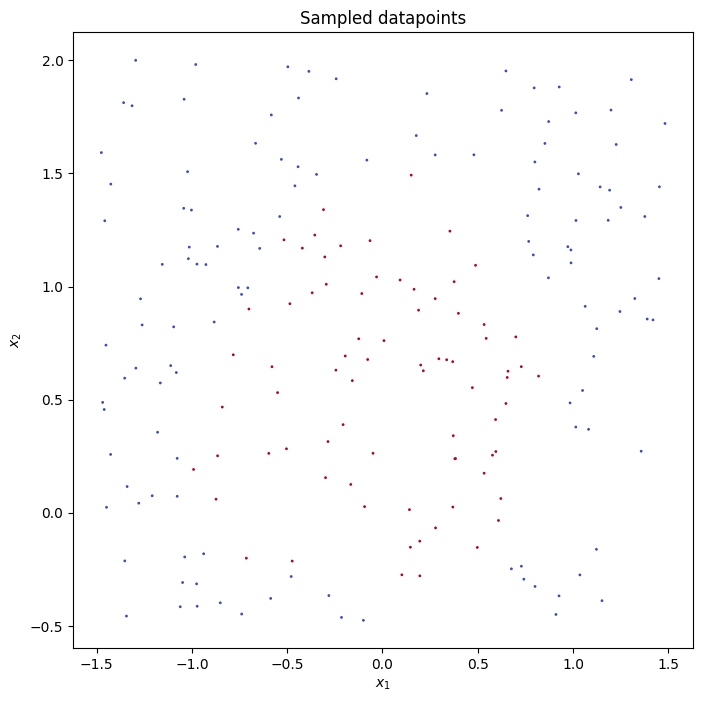

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(df_uniform_train['x0'], df_uniform_train['y0'], c=df_uniform_train['attracted'], cmap='coolwarm', s=1)
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title('Sampled datapoints')
plt.show()

In [8]:
## Define the neural network. The complexity of the network is a hyperparameter.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(2, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, 1)

        #self.bn1 = nn.BatchNorm1d(32)
        #self.bn2 = nn.BatchNorm1d(32)
        #self.bn3 = nn.BatchNorm1d(32)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        #x = self.bn1(x)
        x = torch.relu(self.fc2(x))
        #x = self.bn2(x)
        x = self.fc3(x)
        #x = self.bn3(x)
        return x

In [9]:
def train_model_bce(net, dataset_train, dataset_validation1, dataset_validation001, dataset_validation002, dataset_validation003,
                    dataset_validation004, dataset_validation005, dataset_validation010, batchsize, epochs, lr):
    criterion = nn.BCEWithLogitsLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation001 = DataLoader(dataset_validation001, batch_size=batchsize, shuffle=False)
    dataloader_validation002 = DataLoader(dataset_validation002, batch_size=batchsize, shuffle=False)
    dataloader_validation003 = DataLoader(dataset_validation003, batch_size=batchsize, shuffle=False)
    dataloader_validation004 = DataLoader(dataset_validation004, batch_size=batchsize, shuffle=False)
    dataloader_validation005 = DataLoader(dataset_validation005, batch_size=batchsize, shuffle=False)
    dataloader_validation010 = DataLoader(dataset_validation010, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation001_accuracy_over_epochs = []
    validation002_accuracy_over_epochs = []
    validation003_accuracy_over_epochs = []
    validation004_accuracy_over_epochs = []
    validation005_accuracy_over_epochs = []
    validation010_accuracy_over_epochs = []

    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation001_loss_over_epochs = []
    validation002_loss_over_epochs = []
    validation003_loss_over_epochs = []
    validation004_loss_over_epochs = []
    validation005_loss_over_epochs = []
    validation010_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = (outputs > 0).float()
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation001 = 0
        total_validation001 = 0
        avg_loss_validation001 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation001:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation001 += (predicted == labels).sum().item()
                total_validation001 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation001 += loss.item()
        
        validation001_accuracy = correct_validation001 / total_validation001
        validation001_accuracy_over_epochs.append(validation001_accuracy)
        validation001_loss = avg_loss_validation001 / len(dataloader_validation001)
        validation001_loss_over_epochs.append(validation001_loss)

        correct_validation002 = 0
        total_validation002 = 0
        avg_loss_validation002 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation002:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation002 += (predicted == labels).sum().item()
                total_validation002 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation002 += loss.item()
        
        validation002_accuracy = correct_validation002 / total_validation002
        validation002_accuracy_over_epochs.append(validation002_accuracy)
        validation002_loss = avg_loss_validation002 / len(dataloader_validation002)
        validation002_loss_over_epochs.append(validation002_loss)

        correct_validation003 = 0
        total_validation003 = 0
        avg_loss_validation003 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation003:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation003 += (predicted == labels).sum().item()
                total_validation003 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation003 += loss.item()
        
        validation003_accuracy = correct_validation003 / total_validation003
        validation003_accuracy_over_epochs.append(validation003_accuracy)
        validation003_loss = avg_loss_validation003 / len(dataloader_validation003)
        validation003_loss_over_epochs.append(validation003_loss)

        correct_validation004 = 0
        total_validation004 = 0
        avg_loss_validation004 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation004:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation004 += (predicted == labels).sum().item()
                total_validation004 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation004 += loss.item()
        
        validation004_accuracy = correct_validation004 / total_validation004
        validation004_accuracy_over_epochs.append(validation004_accuracy)
        validation004_loss = avg_loss_validation004 / len(dataloader_validation004)
        validation004_loss_over_epochs.append(validation004_loss)

        correct_validation005 = 0
        total_validation005 = 0
        avg_loss_validation005 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation005:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation005 += (predicted == labels).sum().item()
                total_validation005 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation005 += loss.item()
        
        validation005_accuracy = correct_validation005 / total_validation005
        validation005_accuracy_over_epochs.append(validation005_accuracy)
        validation005_loss = avg_loss_validation005 / len(dataloader_validation005)
        validation005_loss_over_epochs.append(validation005_loss)

        correct_validation010 = 0
        total_validation010 = 0
        avg_loss_validation010 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation010:
                labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = (outputs > 0).float()
                correct_validation010 += (predicted == labels).sum().item()
                total_validation010 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation010 += loss.item()
        
        validation010_accuracy = correct_validation010 / total_validation010
        validation010_accuracy_over_epochs.append(validation010_accuracy)
        validation010_loss = avg_loss_validation010 / len(dataloader_validation010)
        validation010_loss_over_epochs.append(validation010_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        #overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
        overall_progress.set_postfix({'Training Accuracy': training_accuracy, 
                                      'Validation1 Accuracy': validation1_accuracy, 
                                      'Validation001 Accuracy': validation001_accuracy, 
                                      'Validation002 Accuracy': validation002_accuracy, 
                                      'Validation003 Accuracy': validation003_accuracy, 
                                      'Validation004 Accuracy': validation004_accuracy, 
                                      'Validation005 Accuracy': validation005_accuracy, 
                                      'Validation010 Accuracy': validation010_accuracy})
        
        # Plot the decision boundary after each 20% of the epochs
        if (epoch + 1) % (epochs // 5) == 0:
            plot_contour(net)
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training')
    plt.plot(validation1_accuracy_over_epochs, label='Uniform')
    plt.plot(validation001_accuracy_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_accuracy_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_accuracy_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_accuracy_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_accuracy_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_accuracy_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training')
    plt.plot(validation1_loss_over_epochs, label='Uniform')
    plt.plot(validation001_loss_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_loss_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_loss_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_loss_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_loss_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_loss_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    #test_model(net, dataset_train)
    #test_model(net, dataset_validation001)
    #test_model(net, dataset_validation002)
    #test_model(net, dataset_validation003)
    #test_model(net, dataset_validation004)
    #test_model(net, dataset_validation005)
    #test_model(net, dataset_validation010)

In [10]:
def test_model(net, dataset_test):
    net.eval()
    dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)
    features_list = []
    labels_list = []
    probability_list = []
    predictions_list = []
    acc = Accuracy(task = 'binary')

    with torch.no_grad():
        for features, labels in dataloader_test:
            labels = ((labels + 1) / 2).float()
            probability = net(features)
            outputs = (probability > 0).float()
            outputs = outputs.squeeze()

            acc.update(outputs, labels)

            features_list.append(features.numpy())
            labels_list.append(labels.numpy())
            probability_list.append(probability.numpy())
            predictions_list.append(outputs.numpy())
    accuracy = acc.compute()
    print(f'Accuracy: {accuracy}')

    # Concatenate all batches
    features = np.concatenate(features_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    probability = np.concatenate(probability_list, axis=0)
    predictions = np.concatenate(predictions_list, axis=0)

    # Create a 2D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111)

    # Plot the features colored by the predictions
    scatter = ax.scatter(features[:, 0], features[:, 1], c=probability, cmap='coolwarm', vmin=-np.max(np.abs(probability)), vmax=np.max(np.abs(probability)))

    plt.colorbar(scatter)
    plt.xlim([-1.5, 1.5])
    plt.ylim([-0.5, 2])

    plt.show()

    plt.hist(probability, bins=20)
    plt.show()
    return accuracy

In [11]:
net_1 = Net()
train_model_bce(net_1, dataset_train, dataset_validation_uniform, dataset_validation_near_001, dataset_validation_near_002, dataset_validation_near_003,
                dataset_validation_near_004, dataset_validation_near_005, dataset_validation_near_010, batchsize=64, epochs=1500, lr=0.00025)

Overall Training Progress:  20%|██        | 300/1500 [01:36<06:28,  3.09it/s, Training Accuracy=0.875, Validation1 Accuracy=0.831, Validation001 Accuracy=0.481, Validation002 Accuracy=0.485, Validation003 Accuracy=0.531, Validation004 Accuracy=0.502, Validation005 Accuracy=0.495, Validation010 Accuracy=0.509]

NameError: name 'plot_contour' is not defined

Accuracy: 0.9700000286102295


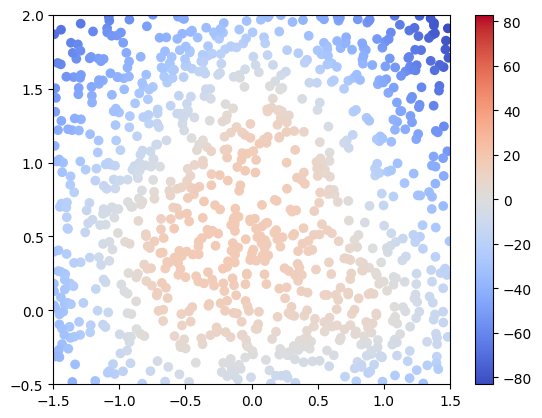

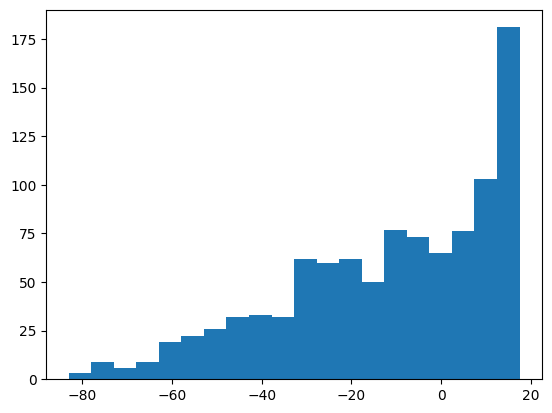

tensor(0.9700)

In [457]:
test_model(net_1, dataset_test_uniform)

Accuracy: 0.5019999742507935


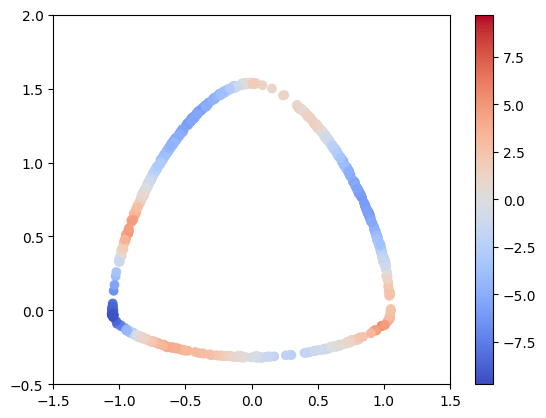

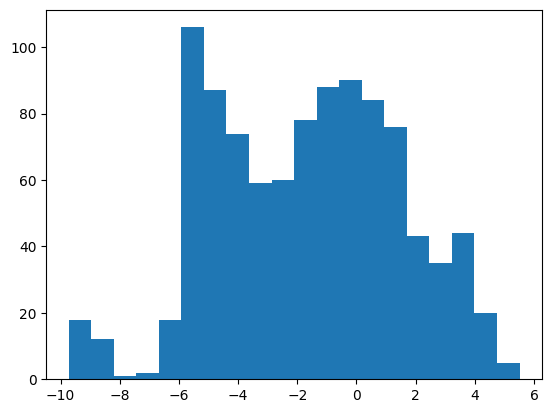

tensor(0.5020)

In [458]:
test_model(net_1, dataset_test_near_001)

Accuracy: 0.5199999809265137


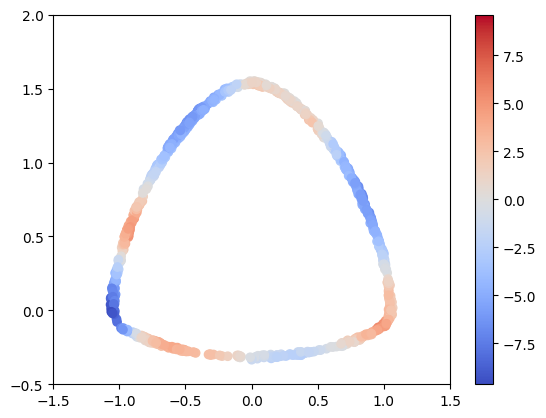

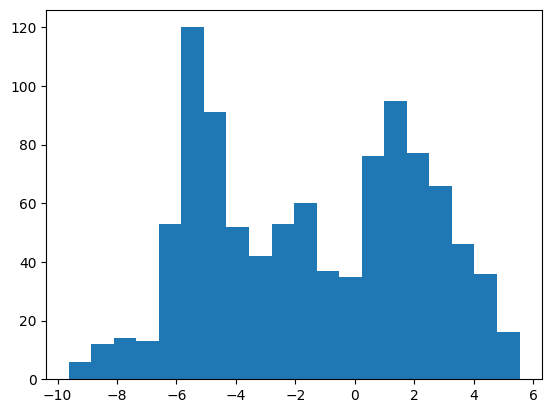

tensor(0.5200)

In [459]:
test_model(net_1, dataset_test_near_002)

Accuracy: 0.5619999766349792


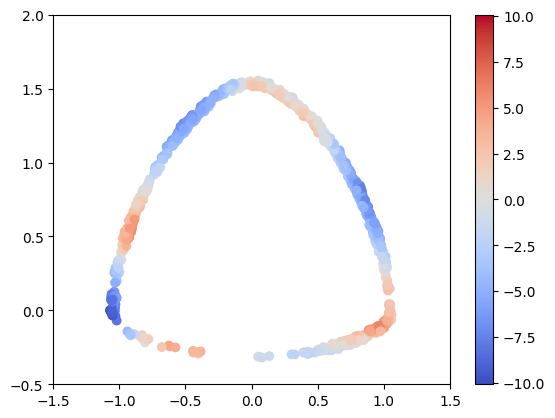

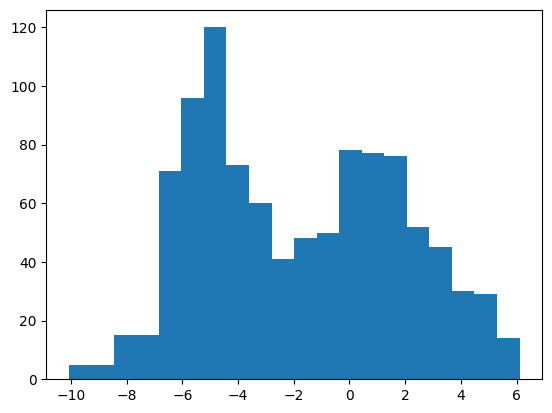

tensor(0.5620)

In [460]:
test_model(net_1, dataset_test_near_003)

Accuracy: 0.531000018119812


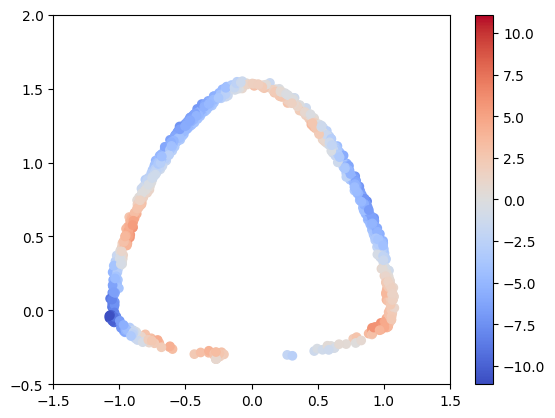

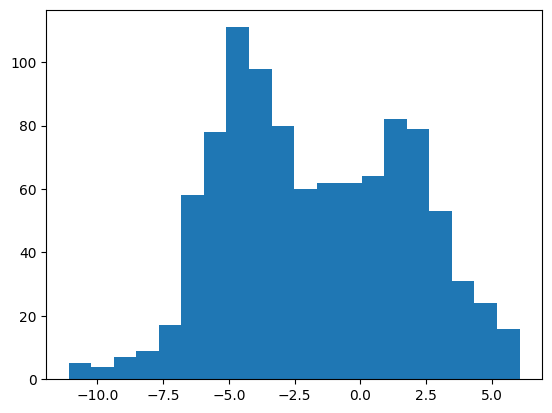

tensor(0.5310)

In [461]:
test_model(net_1, dataset_test_near_004)

Accuracy: 0.5839999914169312


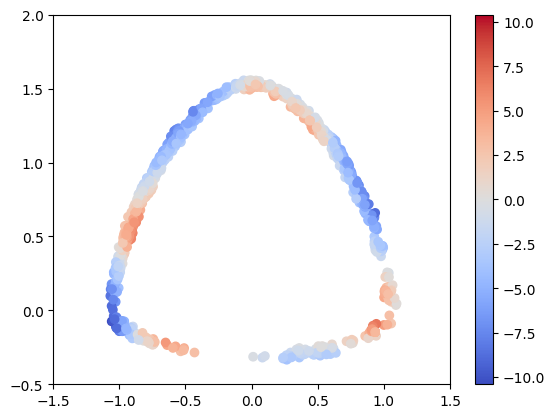

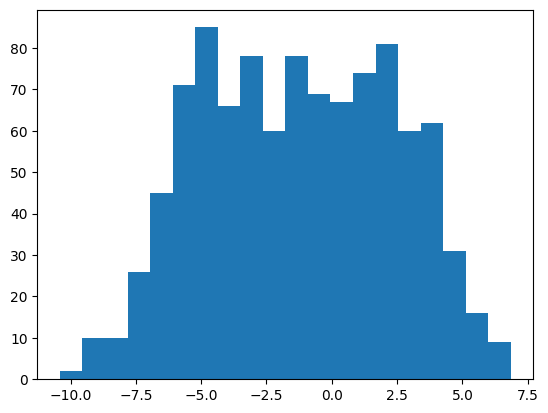

tensor(0.5840)

In [462]:
test_model(net_1, dataset_test_near_005)

Accuracy: 0.6629999876022339


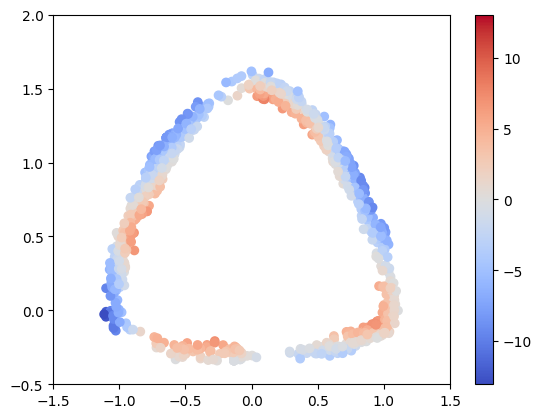

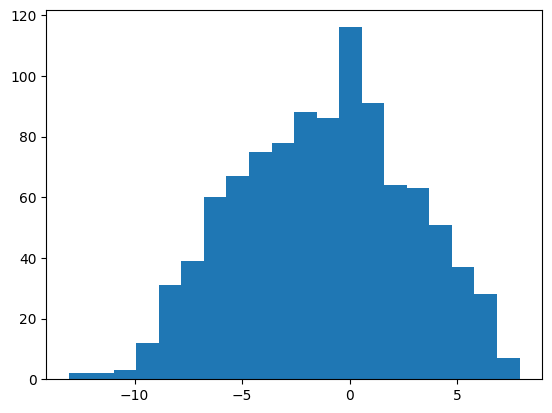

tensor(0.6630)

In [463]:
test_model(net_1, dataset_test_near_010)

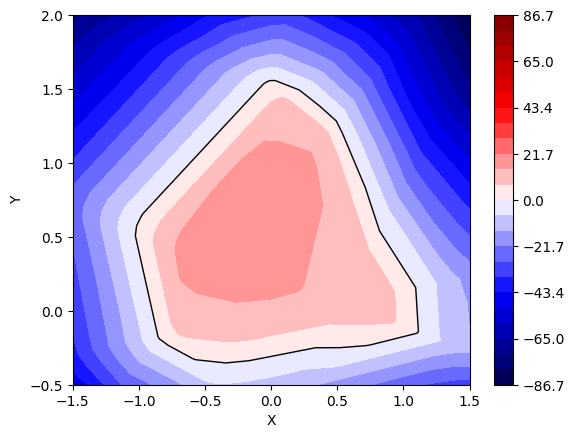

In [464]:
def plot_contour(net):
    x_min, x_max = -1.5, 1.5
    y_min, y_max = -0.5, 2
    resolution = 2000
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    xx, yy = np.meshgrid(x_range, y_range)
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    grid_points_tensor = torch.tensor(grid_points, dtype=torch.float)
    
    with torch.no_grad():
        predictions = net(grid_points_tensor).numpy()
    
    predictions_reshaped = predictions.reshape(xx.shape)
    
    # Ensure the color scale is centered around 0
    vmin = -max(abs(predictions_reshaped.min()), abs(predictions_reshaped.max()))
    vmax = max(abs(predictions_reshaped.min()), abs(predictions_reshaped.max()))
    
    plt.contourf(xx, yy, predictions_reshaped, levels=np.linspace(vmin, vmax, 25), cmap='seismic', vmin=vmin, vmax=vmax)
    plt.colorbar()

    # Draw the decision boundary (contour line at level 0)
    plt.contour(xx, yy, predictions_reshaped, levels=[0], colors='black', linewidths=1)

    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

plot_contour(net_1)

In [209]:
class HingeLoss(nn.Module):
    def __init__(self):
        super(HingeLoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        loss = nn.functional.relu(0.5-y_true * y_pred)
        mean_loss = torch.mean(loss)
        return mean_loss
    
class QuadraticHingeLoss(nn.Module):
    def __init__(self):
        super(QuadraticHingeLoss, self).__init__()

    def forward(self, y_pred, y_true):
        loss = nn.functional.relu(1-y_true * y_pred) ** 2
        mean_loss = torch.mean(loss)
        return mean_loss

In [465]:
def train_model_hinge(net, dataset_train, dataset_validation1, dataset_validation001, dataset_validation002,
                      dataset_validation003, dataset_validation004, dataset_validation005, dataset_validation010, batchsize, epochs, lr):
    criterion = HingeLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation001 = DataLoader(dataset_validation001, batch_size=batchsize, shuffle=False)
    dataloader_validation002 = DataLoader(dataset_validation002, batch_size=batchsize, shuffle=False)
    dataloader_validation003 = DataLoader(dataset_validation003, batch_size=batchsize, shuffle=False)
    dataloader_validation004 = DataLoader(dataset_validation004, batch_size=batchsize, shuffle=False)
    dataloader_validation005 = DataLoader(dataset_validation005, batch_size=batchsize, shuffle=False)
    dataloader_validation010 = DataLoader(dataset_validation010, batch_size=batchsize, shuffle=False)

    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation001_accuracy_over_epochs = []
    validation002_accuracy_over_epochs = []
    validation003_accuracy_over_epochs = []
    validation004_accuracy_over_epochs = []
    validation005_accuracy_over_epochs = []
    validation010_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation001_loss_over_epochs = []
    validation002_loss_over_epochs = []
    validation003_loss_over_epochs = []
    validation004_loss_over_epochs = []
    validation005_loss_over_epochs = []
    validation010_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            #labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation001 = 0
        total_validation001 = 0
        avg_loss_validation001 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation001:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation001 += (predicted == labels).sum().item()
                total_validation001 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation001 += loss.item()
        
        validation001_accuracy = correct_validation001 / total_validation001
        validation001_accuracy_over_epochs.append(validation001_accuracy)
        validation001_loss = avg_loss_validation001 / len(dataloader_validation001)
        validation001_loss_over_epochs.append(validation001_loss)

        correct_validation002 = 0
        total_validation002 = 0
        avg_loss_validation002 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation002:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation002 += (predicted == labels).sum().item()
                total_validation002 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation002 += loss.item()
        
        validation002_accuracy = correct_validation002 / total_validation002
        validation002_accuracy_over_epochs.append(validation002_accuracy)
        validation002_loss = avg_loss_validation002 / len(dataloader_validation002)
        validation002_loss_over_epochs.append(validation002_loss)

        correct_validation003 = 0
        total_validation003 = 0
        avg_loss_validation003 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation003:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation003 += (predicted == labels).sum().item()
                total_validation003 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation003 += loss.item()
        
        validation003_accuracy = correct_validation003 / total_validation003
        validation003_accuracy_over_epochs.append(validation003_accuracy)
        validation003_loss = avg_loss_validation003 / len(dataloader_validation003)
        validation003_loss_over_epochs.append(validation003_loss)

        correct_validation004 = 0
        total_validation004 = 0
        avg_loss_validation004 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation004:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation004 += (predicted == labels).sum().item()
                total_validation004 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation004 += loss.item()
        
        validation004_accuracy = correct_validation004 / total_validation004
        validation004_accuracy_over_epochs.append(validation004_accuracy)
        validation004_loss = avg_loss_validation004 / len(dataloader_validation004)
        validation004_loss_over_epochs.append(validation004_loss)

        correct_validation005 = 0
        total_validation005 = 0
        avg_loss_validation005 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation005:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation005 += (predicted == labels).sum().item()
                total_validation005 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation005 += loss.item()
        
        validation005_accuracy = correct_validation005 / total_validation005
        validation005_accuracy_over_epochs.append(validation005_accuracy)
        validation005_loss = avg_loss_validation005 / len(dataloader_validation005)
        validation005_loss_over_epochs.append(validation005_loss)

        correct_validation010 = 0
        total_validation010 = 0
        avg_loss_validation010 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation010:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation010 += (predicted == labels).sum().item()
                total_validation010 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation010 += loss.item()
        
        validation010_accuracy = correct_validation010 / total_validation010
        validation010_accuracy_over_epochs.append(validation010_accuracy)
        validation010_loss = avg_loss_validation010 / len(dataloader_validation010)
        validation010_loss_over_epochs.append(validation010_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        #overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
        overall_progress.set_postfix({'Training Accuracy': training_accuracy,
                                       'Validation1 Accuracy': validation1_accuracy,
                                        'Validation001 Accuracy': validation001_accuracy, 
                                        'Validation002 Accuracy': validation002_accuracy, 
                                        'Validation003 Accuracy': validation003_accuracy, 
                                        'Validation004 Accuracy': validation004_accuracy, 
                                        'Validation005 Accuracy': validation005_accuracy, 
                                        'Validation010 Accuracy': validation010_accuracy})
        
        # Plot the decision boundary after each 20% of the epochs
        if (epoch + 1) % (epochs // 5) == 0:
            plot_contour(net)
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training')
    plt.plot(validation1_accuracy_over_epochs, label='Uniform')
    plt.plot(validation001_accuracy_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_accuracy_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_accuracy_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_accuracy_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_accuracy_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_accuracy_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training')
    plt.plot(validation1_loss_over_epochs, label='Uniform')
    plt.plot(validation001_loss_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_loss_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_loss_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_loss_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_loss_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_loss_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    #test_model(net, dataset_train)
    #test_model(net, dataset_validation1)
    #test_model(net, dataset_validation001)
    #test_model(net, dataset_validation002)
    #test_model(net, dataset_validation003)
    #test_model(net, dataset_validation004)
    #test_model(net, dataset_validation005)
    #test_model(net, dataset_validation010)

Overall Training Progress:  20%|██        | 200/1000 [01:02<04:09,  3.21it/s, Training Accuracy=0.955, Validation1 Accuracy=0.896, Validation001 Accuracy=0.51, Validation002 Accuracy=0.516, Validation003 Accuracy=0.527, Validation004 Accuracy=0.52, Validation005 Accuracy=0.54, Validation010 Accuracy=0.57]    

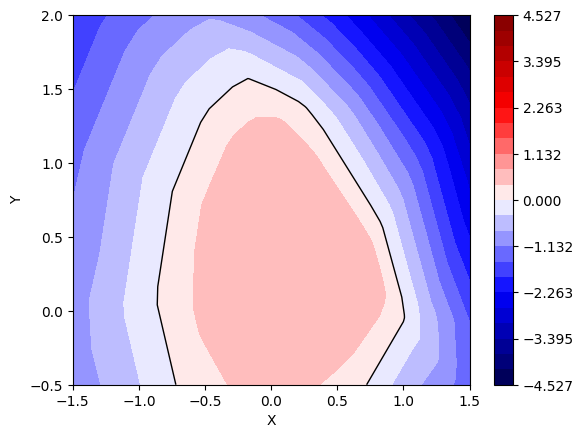

Overall Training Progress:  40%|████      | 400/1000 [02:05<03:08,  3.19it/s, Training Accuracy=0.985, Validation1 Accuracy=0.97, Validation001 Accuracy=0.545, Validation002 Accuracy=0.564, Validation003 Accuracy=0.635, Validation004 Accuracy=0.64, Validation005 Accuracy=0.661, Validation010 Accuracy=0.777]  

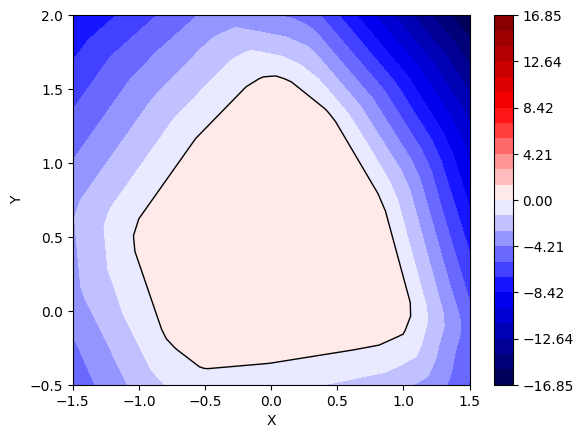

Overall Training Progress:  60%|██████    | 600/1000 [03:09<02:05,  3.19it/s, Training Accuracy=1, Validation1 Accuracy=0.964, Validation001 Accuracy=0.507, Validation002 Accuracy=0.523, Validation003 Accuracy=0.543, Validation004 Accuracy=0.554, Validation005 Accuracy=0.599, Validation010 Accuracy=0.7]      

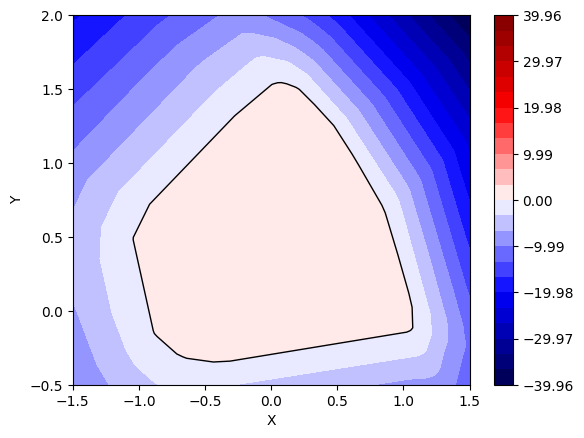

Overall Training Progress:  80%|████████  | 800/1000 [04:12<01:03,  3.14it/s, Training Accuracy=1, Validation1 Accuracy=0.962, Validation001 Accuracy=0.528, Validation002 Accuracy=0.528, Validation003 Accuracy=0.603, Validation004 Accuracy=0.599, Validation005 Accuracy=0.62, Validation010 Accuracy=0.744]     

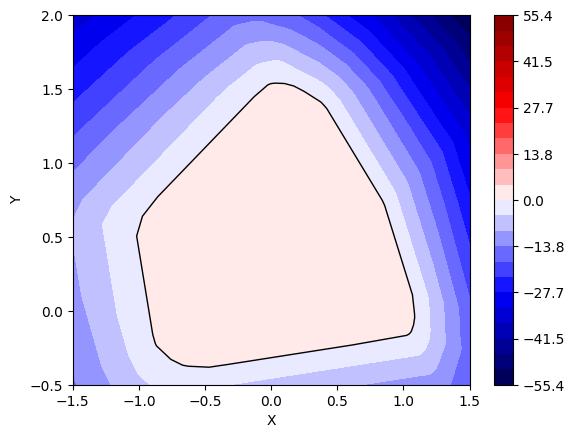

Overall Training Progress: 100%|██████████| 1000/1000 [05:15<00:00,  3.18it/s, Training Accuracy=1, Validation1 Accuracy=0.962, Validation001 Accuracy=0.502, Validation002 Accuracy=0.541, Validation003 Accuracy=0.594, Validation004 Accuracy=0.596, Validation005 Accuracy=0.612, Validation010 Accuracy=0.739]   

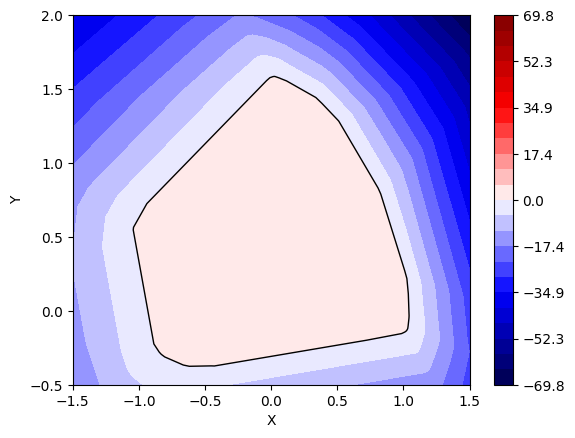

Overall Training Progress: 100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s, Training Accuracy=1, Validation1 Accuracy=0.962, Validation001 Accuracy=0.502, Validation002 Accuracy=0.541, Validation003 Accuracy=0.594, Validation004 Accuracy=0.596, Validation005 Accuracy=0.612, Validation010 Accuracy=0.739]


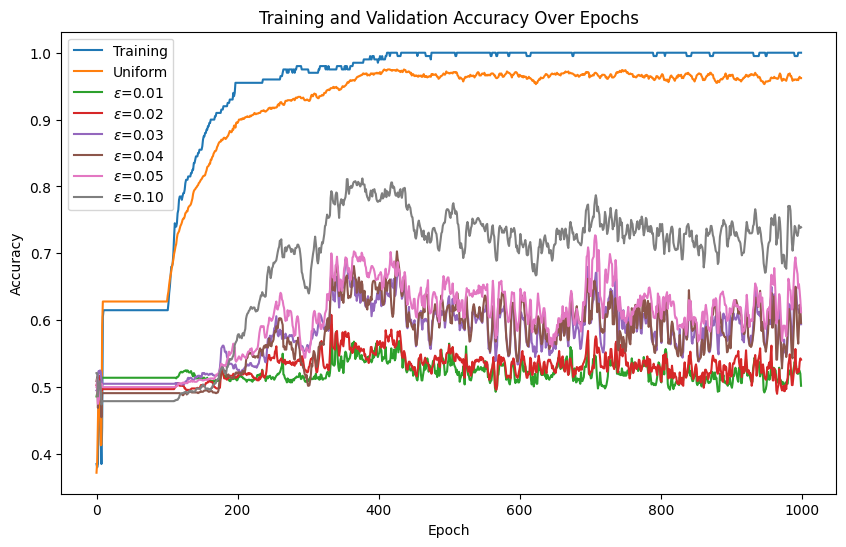

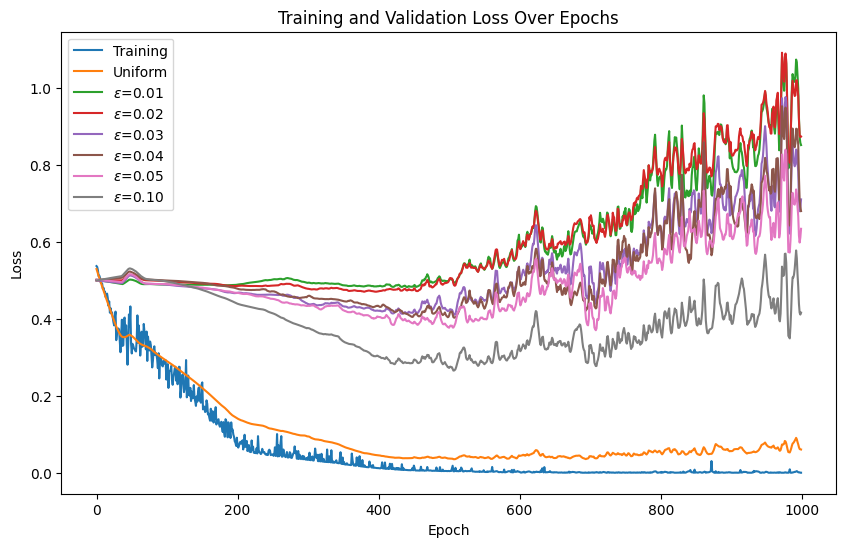

In [466]:
net_hinge = Net()
train_model_hinge(net_hinge, dataset_train, dataset_validation_uniform, dataset_validation_near_001, dataset_validation_near_002, dataset_validation_near_003,
                    dataset_validation_near_004, dataset_validation_near_005, dataset_validation_near_010, batchsize=64, epochs=1000, lr=0.0005)

Accuracy: 0.9789999723434448


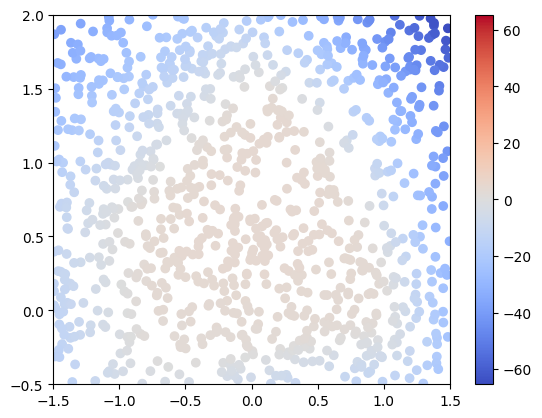

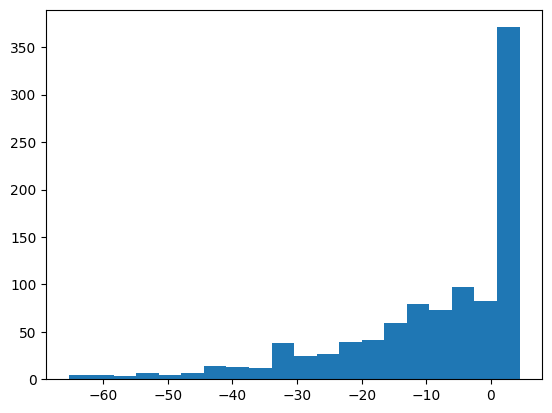

tensor(0.9790)

In [467]:
test_model(net_hinge, dataset_test_uniform)

Accuracy: 0.5220000147819519


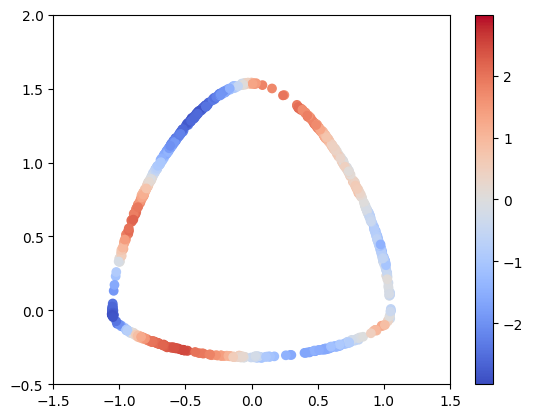

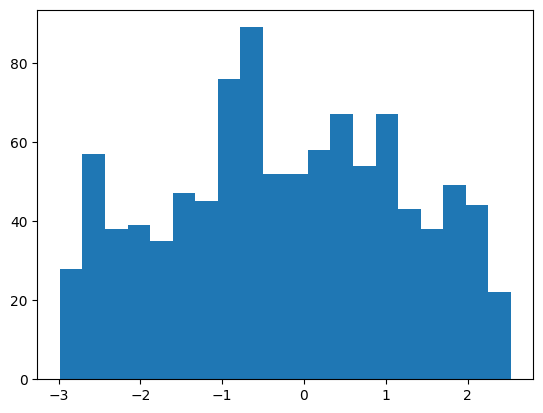

tensor(0.5220)

In [468]:
test_model(net_hinge, dataset_test_near_001)

Accuracy: 0.5440000295639038


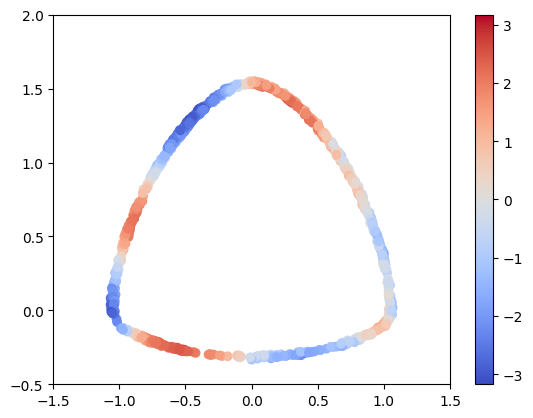

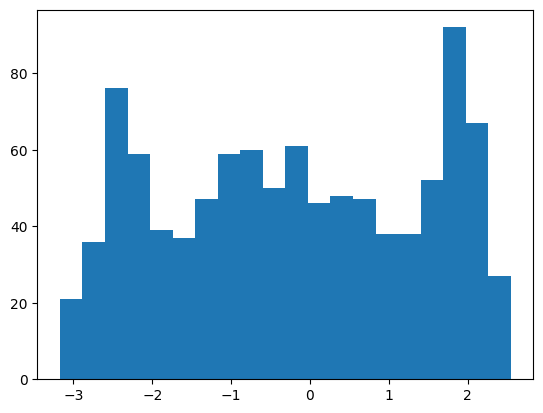

tensor(0.5440)

In [469]:
test_model(net_hinge, dataset_test_near_002)

Accuracy: 0.6079999804496765


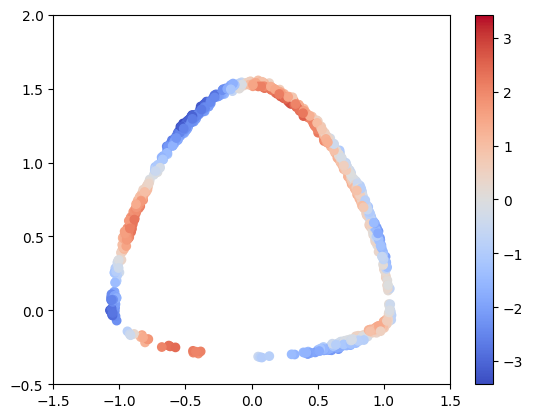

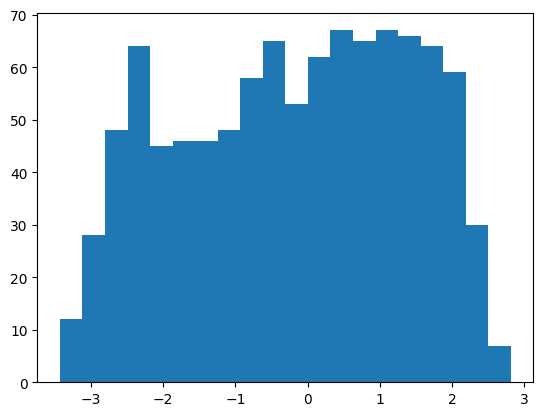

tensor(0.6080)

In [470]:
test_model(net_hinge, dataset_test_near_003)

Accuracy: 0.6209999918937683


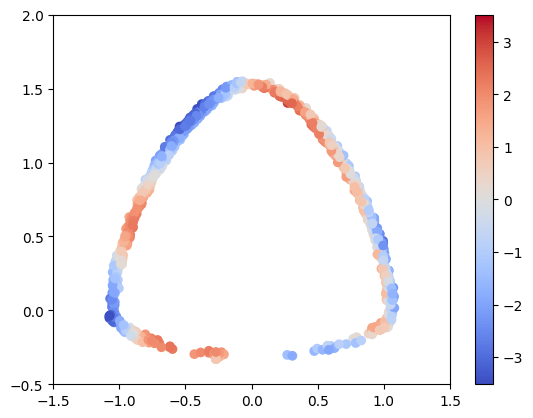

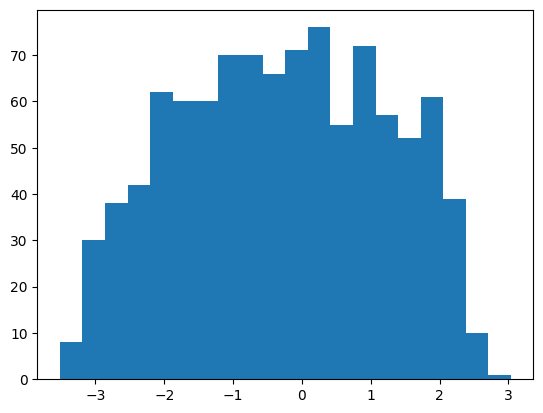

tensor(0.6210)

In [471]:
test_model(net_hinge, dataset_test_near_004)

Accuracy: 0.6140000224113464


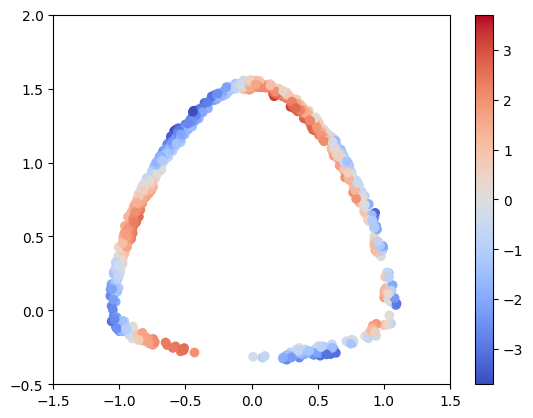

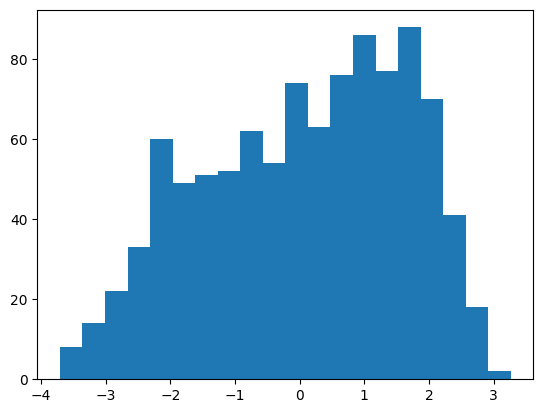

tensor(0.6140)

In [472]:
test_model(net_hinge, dataset_test_near_005)

Accuracy: 0.7329999804496765


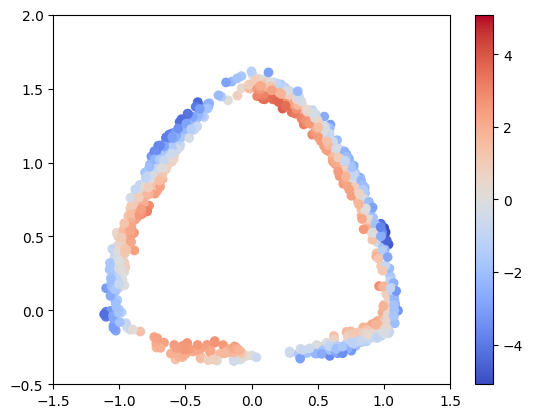

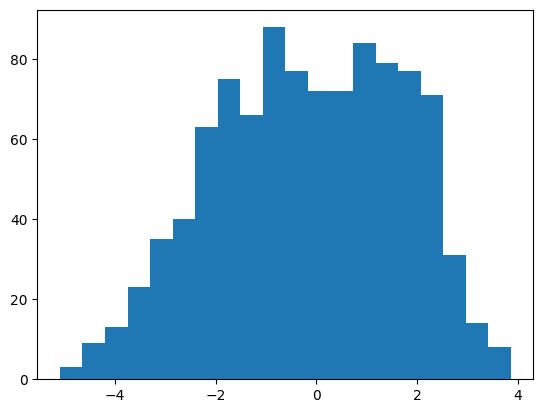

tensor(0.7330)

In [473]:
test_model(net_hinge, dataset_test_near_010)

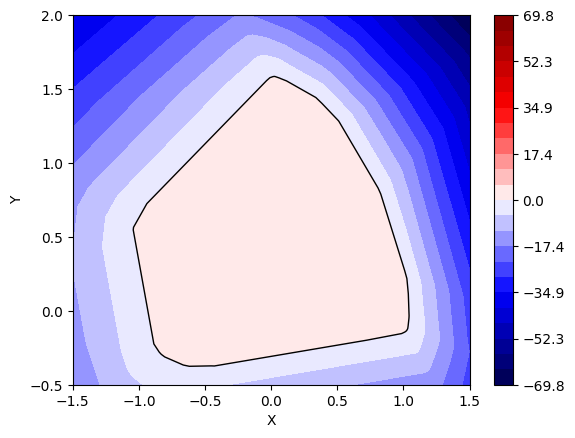

In [474]:
plot_contour(net_hinge)

In [475]:
def train_model_hinge_square(net, dataset_train, dataset_validation1, dataset_validation001, dataset_validation002,
                      dataset_validation003, dataset_validation004, dataset_validation005, dataset_validation010, batchsize, epochs, lr):
    criterion = QuadraticHingeLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation001 = DataLoader(dataset_validation001, batch_size=batchsize, shuffle=False)
    dataloader_validation002 = DataLoader(dataset_validation002, batch_size=batchsize, shuffle=False)
    dataloader_validation003 = DataLoader(dataset_validation003, batch_size=batchsize, shuffle=False)
    dataloader_validation004 = DataLoader(dataset_validation004, batch_size=batchsize, shuffle=False)
    dataloader_validation005 = DataLoader(dataset_validation005, batch_size=batchsize, shuffle=False)
    dataloader_validation010 = DataLoader(dataset_validation010, batch_size=batchsize, shuffle=False)

    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation001_accuracy_over_epochs = []
    validation002_accuracy_over_epochs = []
    validation003_accuracy_over_epochs = []
    validation004_accuracy_over_epochs = []
    validation005_accuracy_over_epochs = []
    validation010_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation001_loss_over_epochs = []
    validation002_loss_over_epochs = []
    validation003_loss_over_epochs = []
    validation004_loss_over_epochs = []
    validation005_loss_over_epochs = []
    validation010_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            #labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            loss = criterion(outputs, labels)
            avg_loss_train += loss.item()
            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation001 = 0
        total_validation001 = 0
        avg_loss_validation001 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation001:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation001 += (predicted == labels).sum().item()
                total_validation001 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation001 += loss.item()
        
        validation001_accuracy = correct_validation001 / total_validation001
        validation001_accuracy_over_epochs.append(validation001_accuracy)
        validation001_loss = avg_loss_validation001 / len(dataloader_validation001)
        validation001_loss_over_epochs.append(validation001_loss)

        correct_validation002 = 0
        total_validation002 = 0
        avg_loss_validation002 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation002:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation002 += (predicted == labels).sum().item()
                total_validation002 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation002 += loss.item()
        
        validation002_accuracy = correct_validation002 / total_validation002
        validation002_accuracy_over_epochs.append(validation002_accuracy)
        validation002_loss = avg_loss_validation002 / len(dataloader_validation002)
        validation002_loss_over_epochs.append(validation002_loss)

        correct_validation003 = 0
        total_validation003 = 0
        avg_loss_validation003 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation003:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation003 += (predicted == labels).sum().item()
                total_validation003 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation003 += loss.item()
        
        validation003_accuracy = correct_validation003 / total_validation003
        validation003_accuracy_over_epochs.append(validation003_accuracy)
        validation003_loss = avg_loss_validation003 / len(dataloader_validation003)
        validation003_loss_over_epochs.append(validation003_loss)

        correct_validation004 = 0
        total_validation004 = 0
        avg_loss_validation004 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation004:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation004 += (predicted == labels).sum().item()
                total_validation004 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation004 += loss.item()
        
        validation004_accuracy = correct_validation004 / total_validation004
        validation004_accuracy_over_epochs.append(validation004_accuracy)
        validation004_loss = avg_loss_validation004 / len(dataloader_validation004)
        validation004_loss_over_epochs.append(validation004_loss)

        correct_validation005 = 0
        total_validation005 = 0
        avg_loss_validation005 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation005:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation005 += (predicted == labels).sum().item()
                total_validation005 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation005 += loss.item()
        
        validation005_accuracy = correct_validation005 / total_validation005
        validation005_accuracy_over_epochs.append(validation005_accuracy)
        validation005_loss = avg_loss_validation005 / len(dataloader_validation005)
        validation005_loss_over_epochs.append(validation005_loss)

        correct_validation010 = 0
        total_validation010 = 0
        avg_loss_validation010 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation010:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation010 += (predicted == labels).sum().item()
                total_validation010 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation010 += loss.item()
        
        validation010_accuracy = correct_validation010 / total_validation010
        validation010_accuracy_over_epochs.append(validation010_accuracy)
        validation010_loss = avg_loss_validation010 / len(dataloader_validation010)
        validation010_loss_over_epochs.append(validation010_loss)
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        #overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
        overall_progress.set_postfix({'Training Accuracy': training_accuracy,
                                       'Validation1 Accuracy': validation1_accuracy,
                                        'Validation001 Accuracy': validation001_accuracy, 
                                        'Validation002 Accuracy': validation002_accuracy, 
                                        'Validation003 Accuracy': validation003_accuracy, 
                                        'Validation004 Accuracy': validation004_accuracy, 
                                        'Validation005 Accuracy': validation005_accuracy, 
                                        'Validation010 Accuracy': validation010_accuracy})
        
        # Plot the decision boundary after each 20% of the epochs
        if (epoch + 1) % (epochs // 5) == 0:
            plot_contour(net)
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training')
    plt.plot(validation1_accuracy_over_epochs, label='Uniform')
    plt.plot(validation001_accuracy_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_accuracy_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_accuracy_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_accuracy_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_accuracy_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_accuracy_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training')
    plt.plot(validation1_loss_over_epochs, label='Uniform')
    plt.plot(validation001_loss_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_loss_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_loss_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_loss_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_loss_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_loss_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()
    
    #test_model(net, dataset_train)
    #test_model(net, dataset_validation1)
    #test_model(net, dataset_validation001)
    #test_model(net, dataset_validation002)
    #test_model(net, dataset_validation003)
    #test_model(net, dataset_validation004)
    #test_model(net, dataset_validation005)
    #test_model(net, dataset_validation010)

Overall Training Progress:  20%|██        | 140/700 [00:43<02:53,  3.22it/s, Training Accuracy=0.87, Validation1 Accuracy=0.815, Validation001 Accuracy=0.509, Validation002 Accuracy=0.504, Validation003 Accuracy=0.507, Validation004 Accuracy=0.488, Validation005 Accuracy=0.509, Validation010 Accuracy=0.501] 

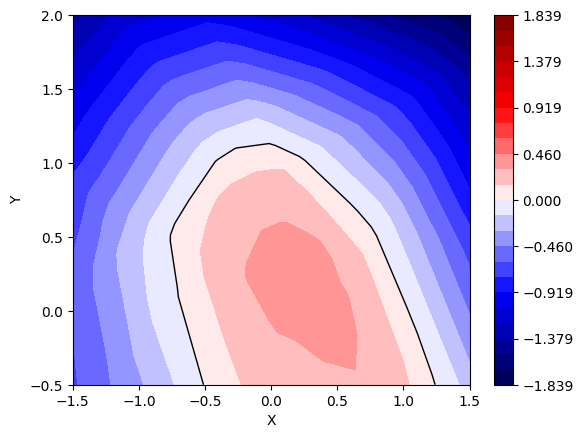

Overall Training Progress:  40%|████      | 280/700 [01:26<02:07,  3.28it/s, Training Accuracy=0.965, Validation1 Accuracy=0.904, Validation001 Accuracy=0.527, Validation002 Accuracy=0.545, Validation003 Accuracy=0.578, Validation004 Accuracy=0.576, Validation005 Accuracy=0.622, Validation010 Accuracy=0.669]

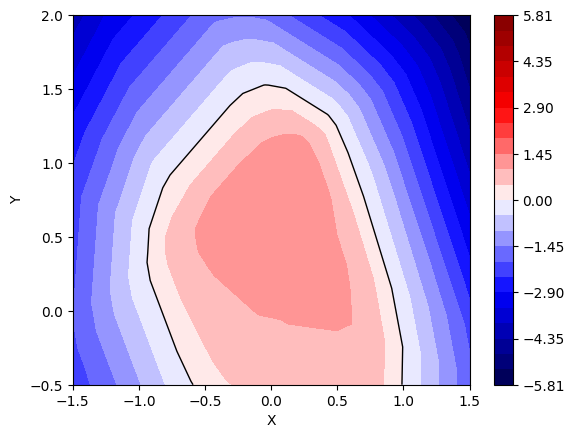

Overall Training Progress:  60%|██████    | 420/700 [02:10<01:28,  3.15it/s, Training Accuracy=0.975, Validation1 Accuracy=0.923, Validation001 Accuracy=0.519, Validation002 Accuracy=0.521, Validation003 Accuracy=0.563, Validation004 Accuracy=0.541, Validation005 Accuracy=0.57, Validation010 Accuracy=0.683] 

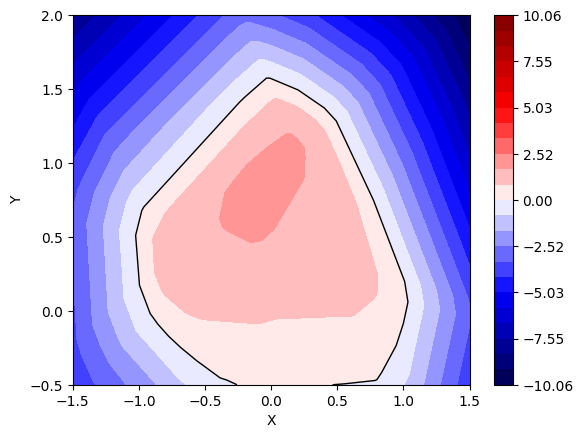

Overall Training Progress:  80%|████████  | 560/700 [02:56<00:44,  3.15it/s, Training Accuracy=0.99, Validation1 Accuracy=0.955, Validation001 Accuracy=0.524, Validation002 Accuracy=0.521, Validation003 Accuracy=0.565, Validation004 Accuracy=0.562, Validation005 Accuracy=0.57, Validation010 Accuracy=0.68]   

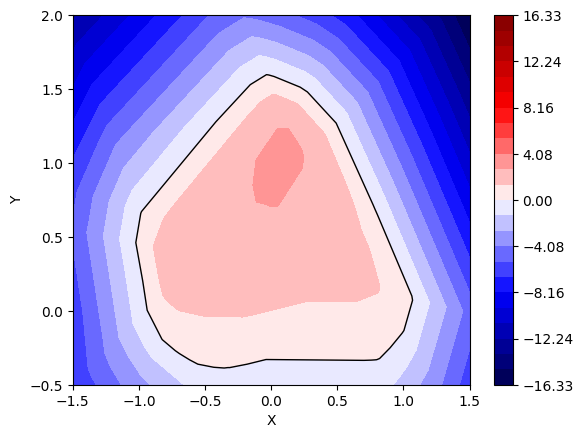

Overall Training Progress: 100%|██████████| 700/700 [03:41<00:00,  3.19it/s, Training Accuracy=1, Validation1 Accuracy=0.967, Validation001 Accuracy=0.511, Validation002 Accuracy=0.516, Validation003 Accuracy=0.564, Validation004 Accuracy=0.555, Validation005 Accuracy=0.587, Validation010 Accuracy=0.723]    

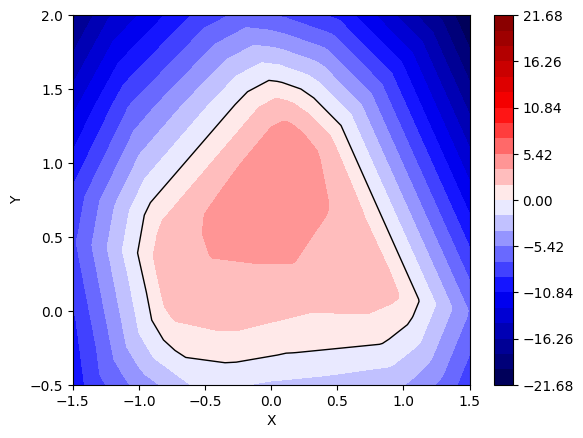

Overall Training Progress: 100%|██████████| 700/700 [03:42<00:00,  3.15it/s, Training Accuracy=1, Validation1 Accuracy=0.967, Validation001 Accuracy=0.511, Validation002 Accuracy=0.516, Validation003 Accuracy=0.564, Validation004 Accuracy=0.555, Validation005 Accuracy=0.587, Validation010 Accuracy=0.723]


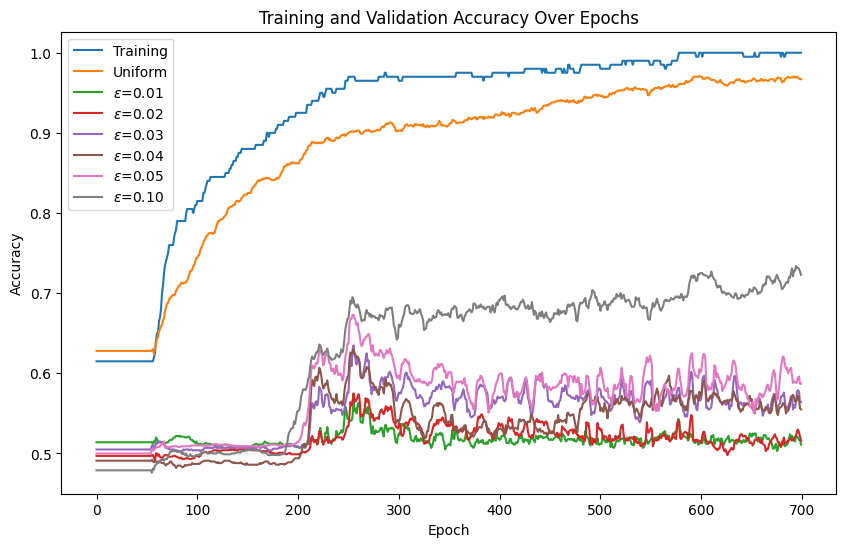

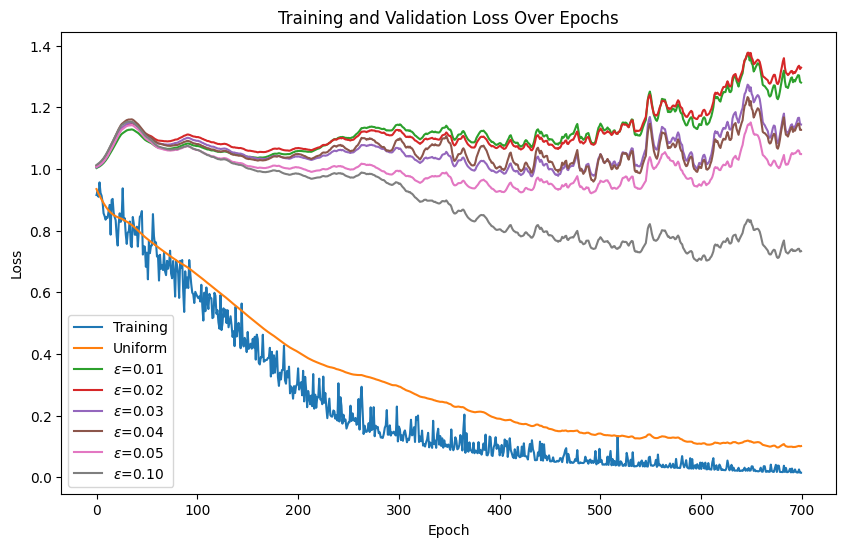

In [476]:
net_hinge_square = Net()
train_model_hinge_square(net_hinge_square, dataset_train, dataset_validation_uniform, dataset_validation_near_001, dataset_validation_near_002, dataset_validation_near_003,
                    dataset_validation_near_004, dataset_validation_near_005, dataset_validation_near_010, batchsize=64, epochs=700, lr=0.0003)

Accuracy: 0.9810000061988831


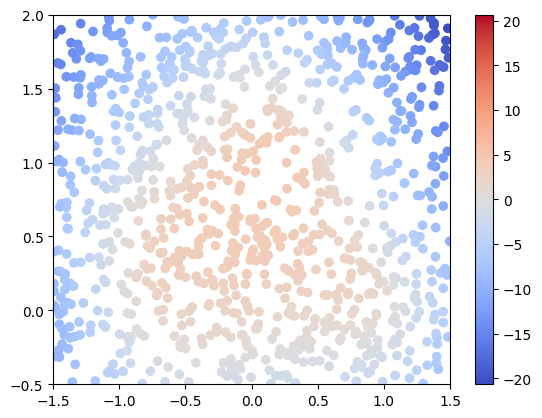

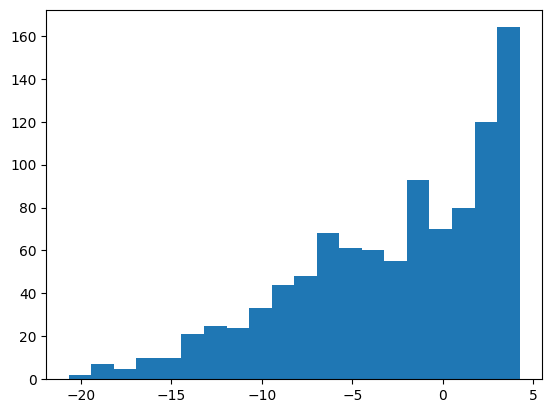

tensor(0.9810)

In [477]:
test_model(net_hinge_square, dataset_test_uniform)

Accuracy: 0.5170000195503235


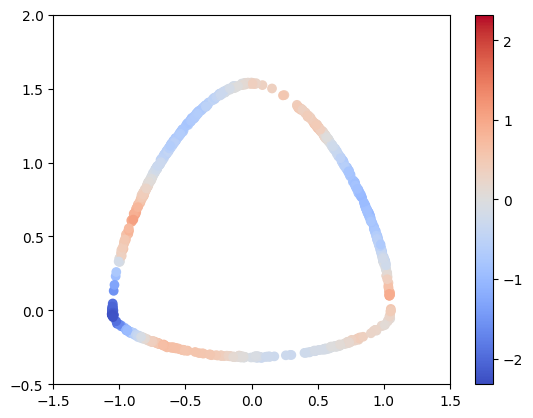

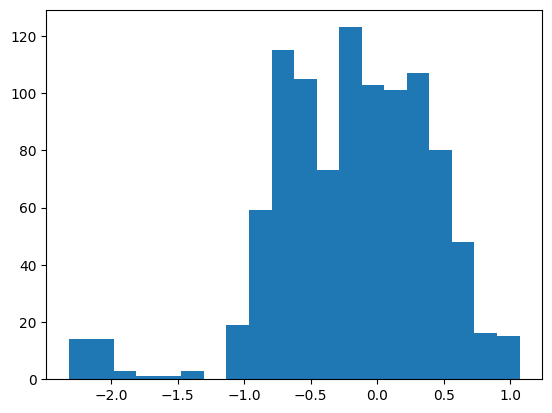

tensor(0.5170)

In [478]:
test_model(net_hinge_square, dataset_test_near_001)

Accuracy: 0.527999997138977


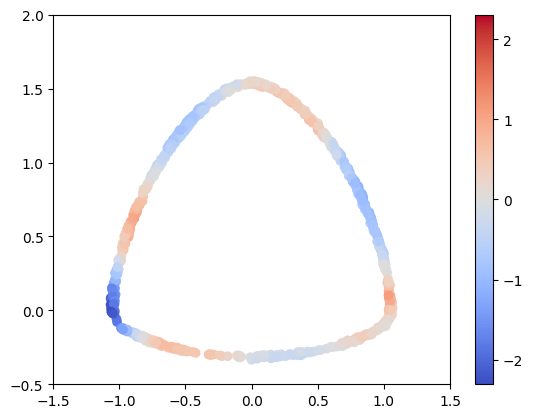

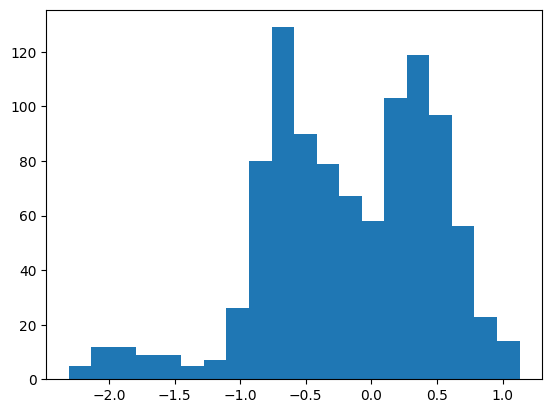

tensor(0.5280)

In [479]:
test_model(net_hinge_square, dataset_test_near_002)

Accuracy: 0.5669999718666077


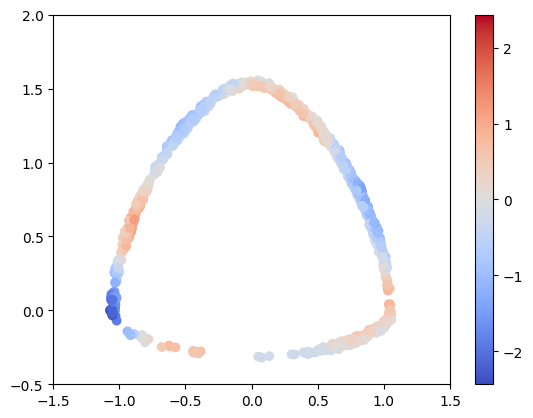

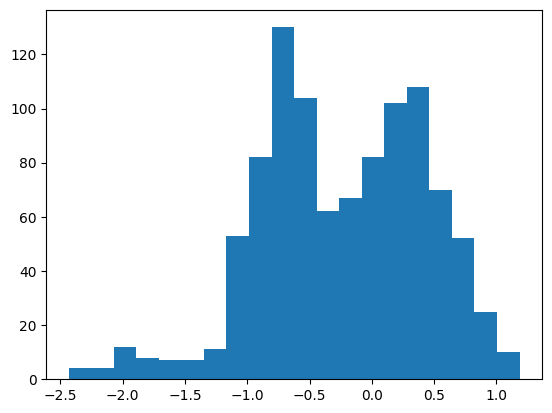

tensor(0.5670)

In [480]:
test_model(net_hinge_square, dataset_test_near_003)

Accuracy: 0.5669999718666077


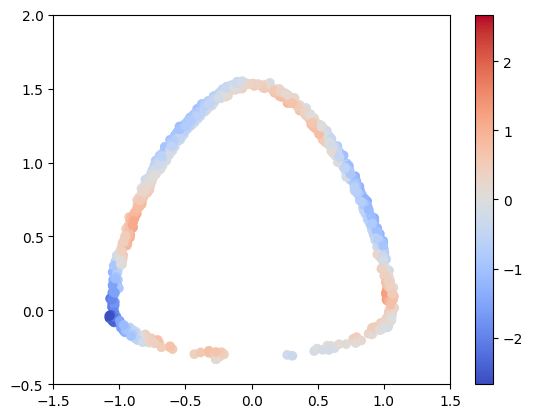

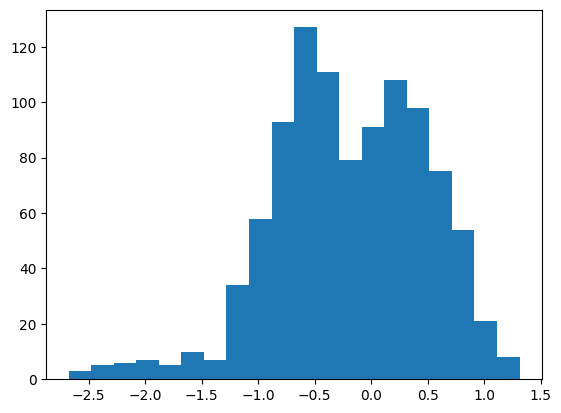

tensor(0.5670)

In [481]:
test_model(net_hinge_square, dataset_test_near_004)

Accuracy: 0.5899999737739563


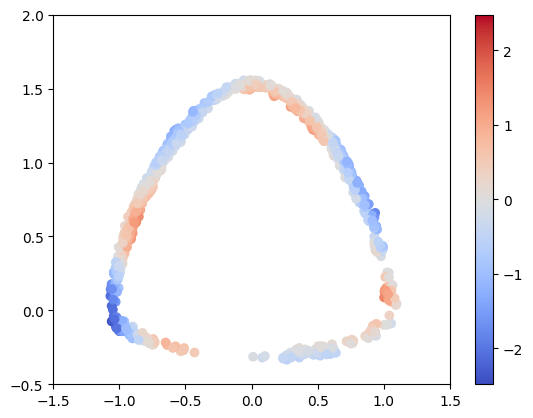

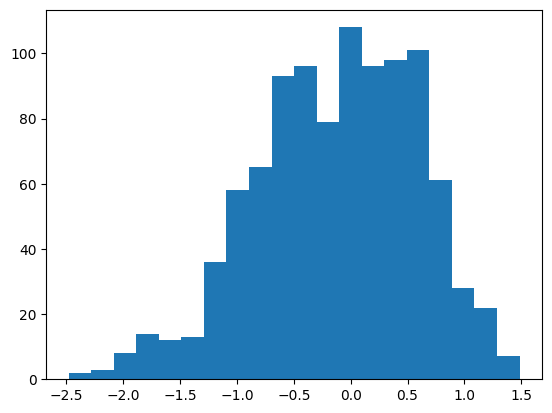

tensor(0.5900)

In [482]:
test_model(net_hinge_square, dataset_test_near_005)

Accuracy: 0.722000002861023


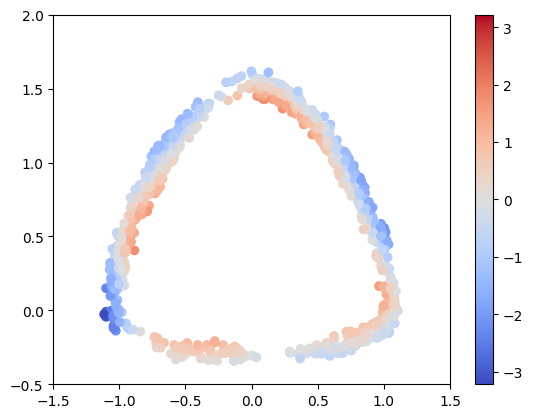

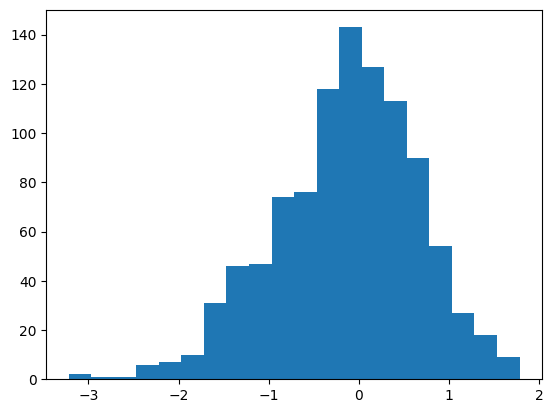

tensor(0.7220)

In [483]:
test_model(net_hinge_square, dataset_test_near_010)

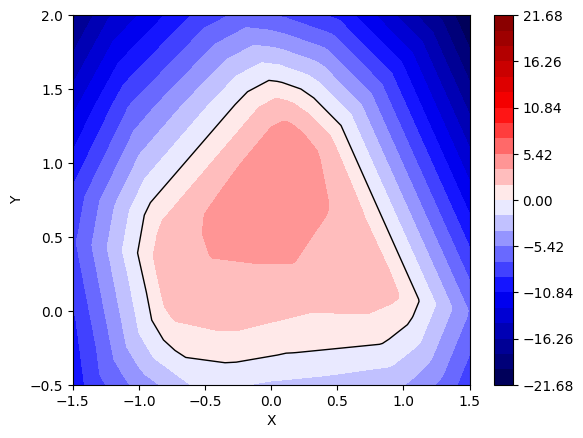

In [484]:
plot_contour(net_hinge_square)

In [338]:
def dynamical_system_vector(point):
    x,y = point[0], point[1]
    xp = (3 * torch.exp(-x**2 - (y - 1/3)**2) * (-2 * x)
           - 3 * torch.exp(-x**2 - (y - 5/3)**2) * (-2 * x)
           - 5 * torch.exp(-(x - 1)**2 - y**2) * (-2 * (x - 1))
           - 5 * torch.exp(-(x + 1)**2 - y**2) * (-2 * (x + 1))
           + 0.8 * x**3)
    yp = (3 * torch.exp(-x**2 - (y - 1/3)**2) * (-2 * (y - 1/3))
           - 3 * torch.exp(-x**2 - (y - 5/3)**2) * (-2 * (y - 5/3))
           - 5 * torch.exp(-(x - 1)**2 - y**2) * (-2 * y)
           - 5 * torch.exp(-(x + 1)**2 - y**2) * (-2 * y)
           + 0.8 * (y - 1/3)**3)
    return torch.tensor([xp, yp], dtype=torch.float32)

def custom_loss_function(model, batch_inputs, var=1e-4):
    batch_loss = 0.0
    def dirac(value, var=var):
        return torch.exp(-(value)**2 / (2 * var**2)) / torch.sqrt(torch.tensor(2 * torch.pi * var**2))
    
    for input_point in batch_inputs:
        input_point = input_point.clone().detach().requires_grad_(True)
        prediction = model(input_point.unsqueeze(0))
        grad_output = torch.ones_like(prediction)
        gradient = torch.autograd.grad(prediction, input_point, grad_outputs=grad_output, create_graph=True)[0]
        dynamical_vector = dynamical_system_vector(input_point)

        #gradient_normalized = gradient / (torch.norm(gradient) + 1e-8)
        #dynamical_vector_normalized = dynamical_vector / (torch.norm(dynamical_vector) + 1e-8)

        # Check if the norm of the gradient or dynamical vector is zero
        gradient_norm = torch.norm(gradient)
        dynamical_vector_norm = torch.norm(dynamical_vector)
        
        if gradient_norm == 0 or dynamical_vector_norm == 0:
            gradient_normalized = torch.zeros_like(gradient)
            dynamical_vector_normalized = torch.zeros_like(dynamical_vector)
        else:
            gradient_normalized = gradient / gradient_norm
            dynamical_vector_normalized = dynamical_vector / dynamical_vector_norm


        inner_product = torch.dot(gradient_normalized, dynamical_vector_normalized)
        dirac_value = dirac(prediction)
        gradient_norm = torch.norm(gradient)
        loss = (inner_product ** 2) * gradient_norm * dirac_value
        batch_loss += loss
    
    # Average the loss over the batch
    batch_loss /= len(batch_inputs)
    
    return batch_loss


In [90]:
'''from torch.autograd import Variable

def find_decision_boundary_batch(f, initial_points, lr=0.001, threshold=0.0001, max_iter=1000):
    f.eval()
    x = Variable(initial_points.clone(), requires_grad=True)
    optimizer = torch.optim.Adam([x], lr=lr)
    converged = torch.zeros(initial_points.size(0), dtype=torch.bool)
    
    for i in range(max_iter):
        optimizer.zero_grad()
        output = f(x)
        loss = (output) ** 2
        loss = loss.mean(dim=1)  # Assuming f returns a tensor of shape (n_points,)
        loss.backward(torch.ones_like(loss))
        optimizer.step()
        
        # Check convergence for each point
        converged |= (loss < threshold)
        
        # Check if points are within the range [-2, 2] x [-2, 2]
        within_bounds = (x[:, 0] >= -2) & (x[:, 0] <= 2) & (x[:, 1] >= -2) & (x[:, 1] <= 2)
        converged &= within_bounds  # Only consider points within bounds as converged
        
        if converged.all():
            print(f"All converged after {i+1} iterations.")
            break
    
    return x, converged


#def collect_converged_points(f, target_count=20):
    #collected_points = []
    #while len(collected_points) < target_count:
        #n_points_needed = 10000
        #initial_points = (torch.rand(n_points_needed, 2) * 4) - 2  # Generate more points
        #x_star_batch, converged = find_decision_boundary_batch(f, initial_points)
        #converged_points = x_star_batch[converged]
        
        # Generate random shifts
        #shifts = (torch.rand(converged_points.size()) * 0.02) - 0.01  # Shifts in the range [-0.01, 0.01]
        #converged_points_shifted = converged_points + shifts
        
        #collected_points.extend(converged_points_shifted.detach().numpy().tolist())  # Convert to list and append
        
    #return torch.tensor(collected_points[:target_count])  # Return the first 1,000 converged points

# Example usage
#collected_points = collect_converged_points(net_4)
#print(f"Collected {len(collected_points)} converged points.")
#outputs = net_4(collected_points)
# Assuming collected_points and outputs are already defined as shown above
#for point, output in zip(collected_points, outputs):
    #print(f"Point: {point}, Output: {output.item()}")

def collect_converged_points_without_noise(f, target_count=20):
    collected_points = []
    while len(collected_points) < target_count:
        n_points_needed = 10000
        initial_points = (torch.rand(n_points_needed, 2) * 4) - 2  # Generate more points
        x_star_batch, converged = find_decision_boundary_batch(f, initial_points)
        converged_points = x_star_batch[converged]
        collected_points.extend(converged_points.detach().numpy().tolist())  # Convert to list and append
        
    return torch.tensor(collected_points[:target_count])  

# Example usage
collected_points = collect_converged_points_without_noise(net_4, target_count=10)
print(f"Collected {len(collected_points)} converged points.")
outputs = net_4(collected_points)
# Assuming collected_points and outputs are already defined as shown above
for point, output in zip(collected_points, outputs):
    print(f"Point: {point}, Output: {output.item()}")'''

Collected 10 converged points.
Point: tensor([ 0.9595, -0.1308]), Output: 1.6093254089355469e-06
Point: tensor([-0.7037, -0.2120]), Output: 1.7881393432617188e-07
Point: tensor([-0.0967,  1.7252]), Output: -0.0012753605842590332
Point: tensor([-0.6967, -0.2142]), Output: -3.159046173095703e-06
Point: tensor([-0.4053, -0.2678]), Output: -3.874301910400391e-06
Point: tensor([-0.2161, -0.2831]), Output: 4.172325134277344e-07
Point: tensor([-0.6183,  0.9956]), Output: -6.026029586791992e-05
Point: tensor([-0.6519,  0.9415]), Output: -6.35981559753418e-05
Point: tensor([-0.4020, -0.2680]), Output: -3.3974647521972656e-06
Point: tensor([-1.0651,  0.2764]), Output: 3.7550926208496094e-06


In [339]:
## Find points on the decision boundary by bisection
def find_decision_boundary_points_bisection(f, target_count, threshold=1e-6):
    collected_points = []
    for i in range(target_count):
        a = torch.rand(2) * 4 - 2
        b = torch.rand(2) * 4 - 2
        while (f(a) * f(b) > 0):
            a = torch.rand(2) * 4 - 2
            b = torch.rand(2) * 4 - 2
        while torch.norm(a - b) > threshold:
            c = (a + b) / 2
            if f(a) * f(c) < 0:
                b = c
            else:
                a = c
        collected_points.append(c)
    return torch.stack(collected_points)

# Example usage
collected_points = find_decision_boundary_points_bisection(net_hinge_square, target_count=2500)
print(f"Collected {len(collected_points)} converged points.")
outputs = net_hinge_square(collected_points)
# Assuming collected_points and outputs are already defined as shown above
for point, output in zip(collected_points, outputs):
    print(f"Point: {point}, Output: {output.item()}")
        

Collected 2500 converged points.
Point: tensor([-0.4021, -0.3535]), Output: -3.6656856536865234e-06
Point: tensor([0.7681, 0.7739]), Output: -3.069639205932617e-06
Point: tensor([-0.0079, -0.3344]), Output: 1.341104507446289e-06
Point: tensor([-0.8044, -0.1986]), Output: -5.424022674560547e-06
Point: tensor([1.0060, 0.1931]), Output: -2.950429916381836e-06
Point: tensor([0.8997, 0.4482]), Output: 2.473592758178711e-06
Point: tensor([-0.8315,  0.8112]), Output: -6.854534149169922e-07
Point: tensor([-0.3085, -0.3572]), Output: 9.834766387939453e-07
Point: tensor([-0.0788, -0.3424]), Output: 1.4901161193847656e-07
Point: tensor([-0.0860,  1.5510]), Output: -1.4007091522216797e-06
Point: tensor([ 0.6692, -0.4180]), Output: 8.642673492431641e-07
Point: tensor([ 0.4601, -0.3449]), Output: -2.7120113372802734e-06
Point: tensor([-0.6753,  1.0128]), Output: -2.086162567138672e-07
Point: tensor([ 0.7245, -0.4324]), Output: 8.642673492431641e-07
Point: tensor([-0.6375, -0.3238]), Output: -3.66568

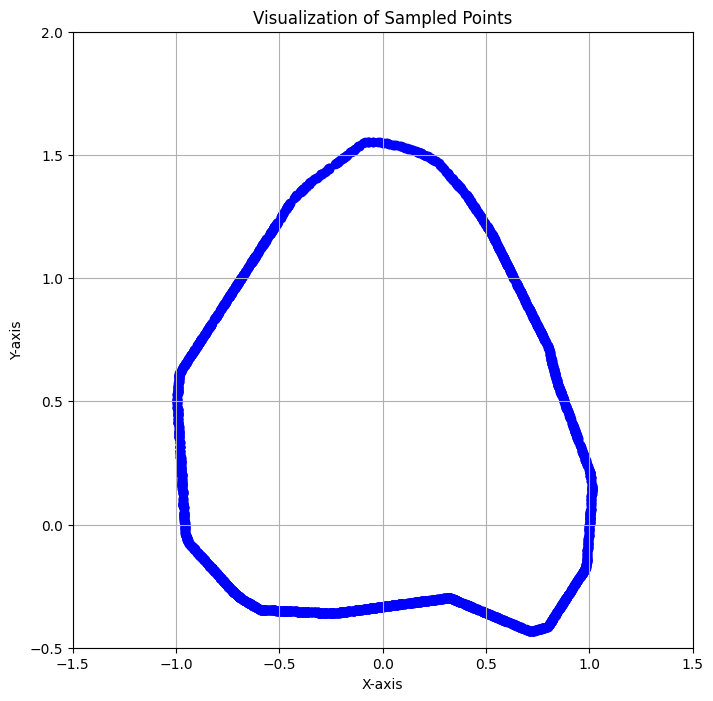

In [344]:
# Assuming collected_points is a tensor of shape (n_points, 2) where n_points >= 1000
x_coords = collected_points[:, 0].numpy()  # Extract x-coordinates
y_coords = collected_points[:, 1].numpy()  # Extract y-coordinates

plt.figure(figsize=(8, 8))  # Set the figure size for better visibility
plt.scatter(x_coords, y_coords, color='blue', label='Converged Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(-1.5, 1.5)
plt.ylim(-0.5, 2)
plt.title('Visualization of Sampled Points')
plt.grid(True)
plt.show()

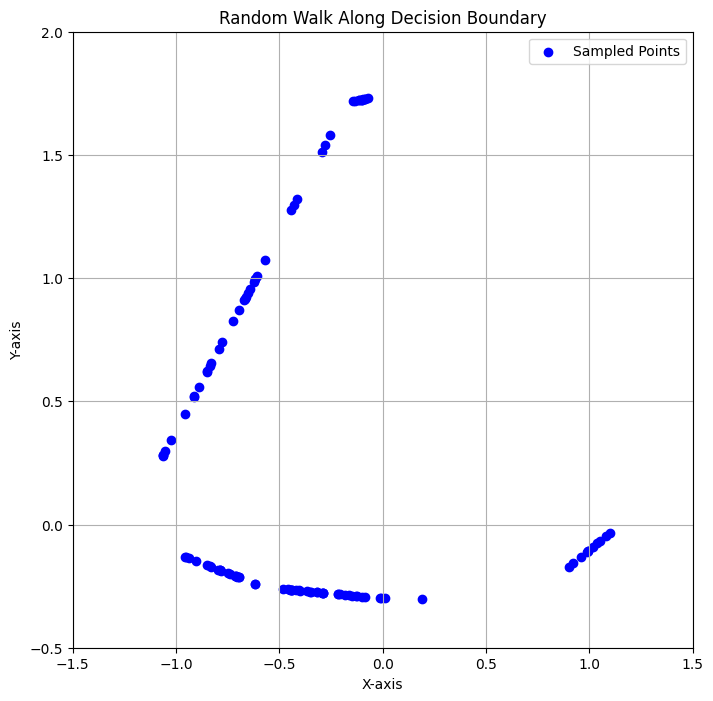

In [92]:
def remove_component_along_direction(a, b):
    projection = (torch.dot(a, b) / torch.dot(b, b)) * b
    return a - projection

def compute_input_gradient(net, input_point):
    input_point = input_point.clone().detach().requires_grad_(True)
    output = net(input_point.unsqueeze(0))
    output.backward()
    gradient = input_point.grad
    return gradient

def random_walk_along_boundary(net, input_tensor, k, learning_rate=0.001, threshold=0.01):
    all_sampled_points = []
    
    for x in input_tensor:
        current_point = x.clone().detach()
        points_collected = [current_point]
        
        while len(points_collected) < k + 1:  # +1 because we start with the initial point
            # Generate random perturbation
            perturbation = torch.randn(2)
            step_size = torch.rand(1).item()
            perturbation = step_size * (perturbation / torch.norm(perturbation))
            
            # Compute gradient vector of f with respect to x
            gradient = compute_input_gradient(net, current_point)
            
            # Compute actual perturbation
            actual_perturbation = remove_component_along_direction(perturbation, gradient)
            
            # Update point to y
            y = current_point + actual_perturbation
            
            #Perform gradient descent to bring y close to decision boundary
            #y = y.clone().detach().requires_grad_(True)
            #optimizer = optim.SGD([y], lr=learning_rate)
            
            #while True:
                #optimizer.zero_grad()
                #output = net(y.unsqueeze(0))
                #loss = torch.abs(output)
                #loss.backward()
                #optimizer.step()
                
                #if loss.item() < threshold:
                    #break
            
            #y = y.clone().detach()
            
            # Check if the point is within the range [-1.5, 1.5] x [-0.5, 2]
            if -1.5 <= y[0].item() <= 1.5 and -0.5 <= y[1].item() <= 2 and -0.3 <= net(y.unsqueeze(0)).item() <= 0.3:
                current_point = y
                points_collected.append(current_point)
            else:
                current_point = x.clone().detach()
        
        all_sampled_points.extend(points_collected)
    
    return torch.stack(all_sampled_points)

# Example usage
# Assuming net is your trained neural network and input_tensor is a tensor of 2D points
input_tensor = collected_points  # Example input tensor
sampled_points = random_walk_along_boundary(net_4, input_tensor, k=10)

# Visualize the sampled points
x_coords = sampled_points[:, 0].numpy()
y_coords = sampled_points[:, 1].numpy()

plt.figure(figsize=(8, 8))
plt.scatter(x_coords, y_coords, color='blue', label='Sampled Points')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(-1.5, 1.5)
plt.ylim(-0.5, 2)
plt.title('Random Walk Along Decision Boundary')
plt.grid(True)
plt.legend()
plt.show()

In [93]:
'''def update_data(dataset_train, collected_points):
    x0 = collected_points[:, 0].flatten()
    y0 = collected_points[:, 1].flatten()
    labels = [0 for i in range(len(x0))]
    data = {'x0': x0, 'y0': y0, 'attracted': labels}
    df_new = pd.DataFrame(data)
    dataset_train.data = pd.concat([dataset_train.data, df_new], ignore_index=True)
    return dataset_train
    '''

In [94]:
'''
class QuadraticHingeLossAdaptive(nn.Module):
    def __init__(self):
        super(QuadraticHingeLossAdaptive, self).__init__()

    def forward(self, y_pred, y_true):
        loss = nn.functional.relu(1-y_true * y_pred) ** 2
        y_true = torch.abs(y_true)
        loss = loss * y_true
        if y_true.sum() == 0:
            return torch.tensor(0.0)
        mean_loss = loss.sum() / y_true.sum()
        return mean_loss
'''

In [95]:
'''
def train_model_dynamical_adaptive_sub(net, dataset_train, dataset_validation1, dataset_validation001, dataset_validation002,
                        dataset_validation003, dataset_validation004, 
                        dataset_validation005, dataset_validation010, batchsize, epochs, lr):
    criterion_sqhinge = QuadraticHingeLossAdaptive()
    #criterion_sqhinge = nn.BCEWithLogitsLoss()
    optimizer = Lion(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation001 = DataLoader(dataset_validation001, batch_size=batchsize, shuffle=False)
    dataloader_validation002 = DataLoader(dataset_validation002, batch_size=batchsize, shuffle=False)
    dataloader_validation003 = DataLoader(dataset_validation003, batch_size=batchsize, shuffle=False)
    dataloader_validation004 = DataLoader(dataset_validation004, batch_size=batchsize, shuffle=False)
    dataloader_validation005 = DataLoader(dataset_validation005, batch_size=batchsize, shuffle=False)
    dataloader_validation010 = DataLoader(dataset_validation010, batch_size=batchsize, shuffle=False)
    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation001_accuracy_over_epochs = []
    validation002_accuracy_over_epochs = []
    validation003_accuracy_over_epochs = []
    validation004_accuracy_over_epochs = []
    validation005_accuracy_over_epochs = []
    validation010_accuracy_over_epochs = []
    training_loss_dynamical_over_epochs = []
    validation1_loss_dynamical_over_epochs = []
    validation001_loss_dynamical_over_epochs = []
    validation002_loss_dynamical_over_epochs = []
    validation003_loss_dynamical_over_epochs = []
    validation004_loss_dynamical_over_epochs = []
    validation005_loss_dynamical_over_epochs = []
    validation010_loss_dynamical_over_epochs = []
    training_loss_hinge_over_epochs = []
    validation1_loss_hinge_over_epochs = []
    validation001_loss_hinge_over_epochs = []
    validation002_loss_hinge_over_epochs = []
    validation003_loss_hinge_over_epochs = []
    validation004_loss_hinge_over_epochs = []
    validation005_loss_hinge_over_epochs = []
    validation010_loss_hinge_over_epochs = []
    
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train_dynamical = 0
        avg_loss_train_hinge = 0
        for features, labels in dataloader_train:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1 ##scale to -1, 1
            #predicted = (outputs > 0).float()
            labels_nonzero_mask = (labels != 0)
            labels_nonzero = labels[labels_nonzero_mask]
            predicted_nonzero = predicted[labels_nonzero_mask]
            correct_train += (predicted_nonzero == labels_nonzero).sum().item()
            total_train += labels_nonzero.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            loss = 0.01*loss_dynamic + 1*loss_hinge # C=constant
            avg_loss_train_dynamical += loss_dynamic.item()
            avg_loss_train_hinge += loss_hinge.item()
            loss.backward()
            optimizer.step()
    
                    
        training_accuracy = correct_train / total_train
        training_loss_dynamical = avg_loss_train_dynamical / len(dataloader_train)
        training_loss_hinge = avg_loss_train_hinge / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_dynamical_over_epochs.append(training_loss_dynamical)
        training_loss_hinge_over_epochs.append(training_loss_hinge)


        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1_dynamical = 0
        avg_loss_validation1_hinge = 0
        for features, labels in dataloader_validation1:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            #predicted = (outputs > 0).float()
            correct_validation1 += (predicted == labels).sum().item()
            total_validation1 += labels.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            #loss = loss_dynamic + loss_hinge
            avg_loss_validation1_dynamical += loss_dynamic.item()
            avg_loss_validation1_hinge += loss_hinge.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss_dynamical = avg_loss_validation1_dynamical / len(dataloader_validation1)
        validation1_loss_dynamical_over_epochs.append(validation1_loss_dynamical)
        validation1_loss_hinge = avg_loss_validation1_hinge / len(dataloader_validation1)
        validation1_loss_hinge_over_epochs.append(validation1_loss_hinge)

        correct_validation001 = 0
        total_validation001 = 0
        avg_loss_validation001_dynamical = 0
        avg_loss_validation001_hinge = 0
        for features, labels in dataloader_validation001:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            #predicted = (outputs > 0).float()
            correct_validation001 += (predicted == labels).sum().item()
            total_validation001 += labels.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            avg_loss_validation001_dynamical += loss_dynamic.item()
            avg_loss_validation001_hinge += loss_hinge.item()
        
        validation001_accuracy = correct_validation001 / total_validation001
        validation001_accuracy_over_epochs.append(validation001_accuracy)
        validation001_loss_dynamical = avg_loss_validation001_dynamical / len(dataloader_validation001)
        validation001_loss_dynamical_over_epochs.append(validation001_loss_dynamical)
        validation001_loss_hinge = avg_loss_validation001_hinge / len(dataloader_validation001)
        validation001_loss_hinge_over_epochs.append(validation001_loss_hinge)

        correct_validation002 = 0
        total_validation002 = 0
        avg_loss_validation002_dynamical = 0
        avg_loss_validation002_hinge = 0
        for features, labels in dataloader_validation002:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            #predicted = (outputs > 0).float()
            correct_validation002 += (predicted == labels).sum().item()
            total_validation002 += labels.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            avg_loss_validation002_dynamical += loss_dynamic.item()
            avg_loss_validation002_hinge += loss_hinge.item()
        
        validation002_accuracy = correct_validation002 / total_validation002
        validation002_accuracy_over_epochs.append(validation002_accuracy)
        validation002_loss_dynamical = avg_loss_validation002_dynamical / len(dataloader_validation002)
        validation002_loss_dynamical_over_epochs.append(validation002_loss_dynamical)
        validation002_loss_hinge = avg_loss_validation002_hinge / len(dataloader_validation002)
        validation002_loss_hinge_over_epochs.append(validation002_loss_hinge)

        correct_validation003 = 0
        total_validation003 = 0
        avg_loss_validation003_dynamical = 0
        avg_loss_validation003_hinge = 0
        for features, labels in dataloader_validation003:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            #predicted = (outputs > 0).float()
            correct_validation003 += (predicted == labels).sum().item()
            total_validation003 += labels.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            avg_loss_validation003_dynamical += loss_dynamic.item()
            avg_loss_validation003_hinge += loss_hinge.item()
        
        validation003_accuracy = correct_validation003 / total_validation003
        validation003_accuracy_over_epochs.append(validation003_accuracy)
        validation003_loss_dynamical = avg_loss_validation003_dynamical / len(dataloader_validation003)
        validation003_loss_dynamical_over_epochs.append(validation003_loss_dynamical)
        validation003_loss_hinge = avg_loss_validation003_hinge / len(dataloader_validation003)
        validation003_loss_hinge_over_epochs.append(validation003_loss_hinge)

        correct_validation004 = 0
        total_validation004 = 0
        avg_loss_validation004_dynamical = 0
        avg_loss_validation004_hinge = 0
        for features, labels in dataloader_validation004:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            #predicted = (outputs > 0).float()
            correct_validation004 += (predicted == labels).sum().item()
            total_validation004 += labels.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            avg_loss_validation004_dynamical += loss_dynamic.item()
            avg_loss_validation004_hinge += loss_hinge.item()
        
        validation004_accuracy = correct_validation004 / total_validation004
        validation004_accuracy_over_epochs.append(validation004_accuracy)
        validation004_loss_dynamical = avg_loss_validation004_dynamical / len(dataloader_validation004)
        validation004_loss_dynamical_over_epochs.append(validation004_loss_dynamical)
        validation004_loss_hinge = avg_loss_validation004_hinge / len(dataloader_validation004)
        validation004_loss_hinge_over_epochs.append(validation004_loss_hinge)

        correct_validation005 = 0
        total_validation005 = 0
        avg_loss_validation005_dynamical = 0
        avg_loss_validation005_hinge = 0
        for features, labels in dataloader_validation005:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            #predicted = (outputs > 0).float()
            correct_validation005 += (predicted == labels).sum().item()
            total_validation005 += labels.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            avg_loss_validation005_dynamical += loss_dynamic.item()
            avg_loss_validation005_hinge += loss_hinge.item()
        
        validation005_accuracy = correct_validation005 / total_validation005
        validation005_accuracy_over_epochs.append(validation005_accuracy)
        validation005_loss_dynamical = avg_loss_validation005_dynamical / len(dataloader_validation005)
        validation005_loss_dynamical_over_epochs.append(validation005_loss_dynamical)
        validation005_loss_hinge = avg_loss_validation005_hinge / len(dataloader_validation005)
        validation005_loss_hinge_over_epochs.append(validation005_loss_hinge)

        correct_validation010 = 0
        total_validation010 = 0
        avg_loss_validation010_dynamical = 0
        avg_loss_validation010_hinge = 0
        for features, labels in dataloader_validation010:
            #labels = ((labels + 1) / 2).float()
            features.requires_grad = True
            labels = labels.view(-1)
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            #predicted = (outputs > 0).float()
            correct_validation010 += (predicted == labels).sum().item()
            total_validation010 += labels.size(0)
            loss_dynamic = custom_loss_function(net, features)
            loss_hinge =  criterion_sqhinge(outputs, labels)
            avg_loss_validation010_dynamical += loss_dynamic.item()
            avg_loss_validation010_hinge += loss_hinge.item()
        
        validation010_accuracy = correct_validation010 / total_validation010
        validation010_accuracy_over_epochs.append(validation010_accuracy)
        validation010_loss_dynamical = avg_loss_validation010_dynamical / len(dataloader_validation010)
        validation010_loss_dynamical_over_epochs.append(validation010_loss_dynamical)
        validation010_loss_hinge = avg_loss_validation010_hinge / len(dataloader_validation010)
        validation010_loss_hinge_over_epochs.append(validation010_loss_hinge)
        
        overall_progress.update(1)
        #overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
        overall_progress.set_postfix({'Training Accuracy': training_accuracy,
                                        'Validation1 Accuracy': validation1_accuracy,
                                         'Validation001 Accuracy': validation001_accuracy, 
                                         'Validation002 Accuracy': validation002_accuracy, 
                                         'Validation003 Accuracy': validation003_accuracy, 
                                         'Validation004 Accuracy': validation004_accuracy, 
                                         'Validation005 Accuracy': validation005_accuracy, 
                                         'Validation010 Accuracy': validation010_accuracy})
    
    overall_progress.close()
    
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training')
    plt.plot(validation1_accuracy_over_epochs, label='Uniform')
    plt.plot(validation001_accuracy_over_epochs, label='$\delta$=0.01')
    plt.plot(validation002_accuracy_over_epochs, label='$\delta$=0.02')
    plt.plot(validation003_accuracy_over_epochs, label='$\delta$=0.03')
    plt.plot(validation004_accuracy_over_epochs, label='$\delta$=0.04')
    plt.plot(validation005_accuracy_over_epochs, label='$\delta$=0.05')
    plt.plot(validation010_accuracy_over_epochs, label='$\delta$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_dynamical_over_epochs, label='Training')
    plt.plot(validation1_loss_dynamical_over_epochs, label='Uniform')
    plt.plot(validation001_loss_dynamical_over_epochs, label='$\delta$=0.01')
    plt.plot(validation002_loss_dynamical_over_epochs, label='$\delta$=0.02')
    plt.plot(validation003_loss_dynamical_over_epochs, label='$\delta$=0.03')
    plt.plot(validation004_loss_dynamical_over_epochs, label='$\delta$=0.04')
    plt.plot(validation005_loss_dynamical_over_epochs, label='$\delta$=0.05')
    plt.plot(validation010_loss_dynamical_over_epochs, label='$\delta$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Dynamical Loss Over Epochs')
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_hinge_over_epochs, label='Training')
    plt.plot(validation1_loss_hinge_over_epochs, label='Uniform')
    plt.plot(validation001_loss_hinge_over_epochs, label='$\delta$=0.01')
    plt.plot(validation002_loss_hinge_over_epochs, label='$\delta$=0.02')
    plt.plot(validation003_loss_hinge_over_epochs, label='$\delta$=0.03')
    plt.plot(validation004_loss_hinge_over_epochs, label='$\delta$=0.04')
    plt.plot(validation005_loss_hinge_over_epochs, label='$\delta$=0.05')
    plt.plot(validation010_loss_hinge_over_epochs, label='$\delta$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Square Hinge Loss Over Epochs')
    plt.legend()
    plt.show()
    
    #test_model(net, dataset_train)
    test_model(net, dataset_validation1)
    test_model(net, dataset_validation001)
    test_model(net, dataset_validation002)
    test_model(net, dataset_validation003)
    test_model(net, dataset_validation004)
    test_model(net, dataset_validation005)
    test_model(net, dataset_validation010)

    plot_contour(net)'''

In [96]:
'''def train_model_dynamical_adaptive(net, dataset_train, dataset_validation1, dataset_validation001, dataset_validation002,
                        dataset_validation003, dataset_validation004, 
                        dataset_validation005, dataset_validation010, batchsize, epochs, lr, iterations=20):
    C = 1
    for i in range(iterations):
        if (i > 0):
            epochs = 400
        train_model_dynamical_adaptive_sub(net, dataset_train, dataset_validation1, dataset_validation001, dataset_validation002,
                        dataset_validation003, dataset_validation004, 
                        dataset_validation005, dataset_validation010, batchsize, epochs, C*lr)
        collected_points = collect_converged_points_without_noise(net, target_count=20)
        collected_data = random_walk_along_boundary(net, collected_points, k=10)
        dataset_train = update_data(dataset_train, collected_data)
        #C = C * 0.9'''

In [445]:
def train_model_dynamical_adaptive(net, dataset_train, dataset_validation1, dataset_validation001, dataset_validation002,
                      dataset_validation003, dataset_validation004, dataset_validation005, dataset_validation010, batchsize, epochs, lr):
    criterion = HingeLoss()
    #optimizer = optim.Adam(net.parameters(), lr=lr)
    optimizer = Lion(net.parameters(), lr=lr)
    dataloader_train = DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
    dataloader_validation1 = DataLoader(dataset_validation1, batch_size=batchsize, shuffle=False)
    dataloader_validation001 = DataLoader(dataset_validation001, batch_size=batchsize, shuffle=False)
    dataloader_validation002 = DataLoader(dataset_validation002, batch_size=batchsize, shuffle=False)
    dataloader_validation003 = DataLoader(dataset_validation003, batch_size=batchsize, shuffle=False)
    dataloader_validation004 = DataLoader(dataset_validation004, batch_size=batchsize, shuffle=False)
    dataloader_validation005 = DataLoader(dataset_validation005, batch_size=batchsize, shuffle=False)
    dataloader_validation010 = DataLoader(dataset_validation010, batch_size=batchsize, shuffle=False)

    
    training_accuracy_over_epochs = []
    validation1_accuracy_over_epochs = []
    validation001_accuracy_over_epochs = []
    validation002_accuracy_over_epochs = []
    validation003_accuracy_over_epochs = []
    validation004_accuracy_over_epochs = []
    validation005_accuracy_over_epochs = []
    validation010_accuracy_over_epochs = []
    training_loss_over_epochs = []
    validation1_loss_over_epochs = []
    validation001_loss_over_epochs = []
    validation002_loss_over_epochs = []
    validation003_loss_over_epochs = []
    validation004_loss_over_epochs = []
    validation005_loss_over_epochs = []
    validation010_loss_over_epochs = []

    dynamical_loss_over_epochs = []
    
    # Set up the overall progress bar
    overall_progress = tqdm(total=epochs, desc='Overall Training Progress')
    
    for epoch in range(epochs):
        net.train()
        correct_train = 0
        total_train = 0
        avg_loss_train = 0
        for features, labels in dataloader_train:
            #labels = ((labels + 1) / 2).float()
            labels = labels.view(-1)
            optimizer.zero_grad()
            outputs = net(features).view(-1)
            predicted = ((outputs > 0).float() * 2) - 1
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)
            hingeloss = criterion(outputs, labels)
            avg_loss_train += hingeloss.item()

            collected_data = find_decision_boundary_points_bisection(net, target_count=2500)
            #collected_data = random_walk_along_boundary(net, collected_points, k=25)
            dynamical_loss = custom_loss_function(net, collected_data, var=0.01)
            loss = hingeloss + 0.001 * dynamical_loss #C=constant
            dynamical_loss_over_epochs.append(dynamical_loss.item())

            loss.backward()
            optimizer.step()
                    
        training_accuracy = correct_train / total_train
        training_loss = avg_loss_train / len(dataloader_train)
        training_accuracy_over_epochs.append(training_accuracy)
        training_loss_over_epochs.append(training_loss)

        
        net.eval()
        correct_validation1 = 0
        total_validation1 = 0
        avg_loss_validation1 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation1:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation1 += (predicted == labels).sum().item()
                total_validation1 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation1 += loss.item()
        
        validation1_accuracy = correct_validation1 / total_validation1
        validation1_accuracy_over_epochs.append(validation1_accuracy)
        validation1_loss = avg_loss_validation1 / len(dataloader_validation1)
        validation1_loss_over_epochs.append(validation1_loss)

        correct_validation001 = 0
        total_validation001 = 0
        avg_loss_validation001 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation001:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation001 += (predicted == labels).sum().item()
                total_validation001 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation001 += loss.item()
        
        validation001_accuracy = correct_validation001 / total_validation001
        validation001_accuracy_over_epochs.append(validation001_accuracy)
        validation001_loss = avg_loss_validation001 / len(dataloader_validation001)
        validation001_loss_over_epochs.append(validation001_loss)

        correct_validation002 = 0
        total_validation002 = 0
        avg_loss_validation002 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation002:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation002 += (predicted == labels).sum().item()
                total_validation002 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation002 += loss.item()
        
        validation002_accuracy = correct_validation002 / total_validation002
        validation002_accuracy_over_epochs.append(validation002_accuracy)
        validation002_loss = avg_loss_validation002 / len(dataloader_validation002)
        validation002_loss_over_epochs.append(validation002_loss)

        correct_validation003 = 0
        total_validation003 = 0
        avg_loss_validation003 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation003:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation003 += (predicted == labels).sum().item()
                total_validation003 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation003 += loss.item()
        
        validation003_accuracy = correct_validation003 / total_validation003
        validation003_accuracy_over_epochs.append(validation003_accuracy)
        validation003_loss = avg_loss_validation003 / len(dataloader_validation003)
        validation003_loss_over_epochs.append(validation003_loss)

        correct_validation004 = 0
        total_validation004 = 0
        avg_loss_validation004 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation004:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation004 += (predicted == labels).sum().item()
                total_validation004 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation004 += loss.item()
        
        validation004_accuracy = correct_validation004 / total_validation004
        validation004_accuracy_over_epochs.append(validation004_accuracy)
        validation004_loss = avg_loss_validation004 / len(dataloader_validation004)
        validation004_loss_over_epochs.append(validation004_loss)

        correct_validation005 = 0
        total_validation005 = 0
        avg_loss_validation005 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation005:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation005 += (predicted == labels).sum().item()
                total_validation005 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation005 += loss.item()
        
        validation005_accuracy = correct_validation005 / total_validation005
        validation005_accuracy_over_epochs.append(validation005_accuracy)
        validation005_loss = avg_loss_validation005 / len(dataloader_validation005)
        validation005_loss_over_epochs.append(validation005_loss)

        correct_validation010 = 0
        total_validation010 = 0
        avg_loss_validation010 = 0
        with torch.no_grad():
            for features, labels in dataloader_validation010:
                #labels = ((labels + 1) / 2).float()
                labels = labels.view(-1)
                outputs = net(features).view(-1)
                predicted = ((outputs > 0).float() * 2) - 1
                correct_validation010 += (predicted == labels).sum().item()
                total_validation010 += labels.size(0)
                loss = criterion(outputs, labels)
                avg_loss_validation010 += loss.item()
        
        validation010_accuracy = correct_validation010 / total_validation010
        validation010_accuracy_over_epochs.append(validation010_accuracy)
        validation010_loss = avg_loss_validation010 / len(dataloader_validation010)
        validation010_loss_over_epochs.append(validation010_loss)


        #collected_data = find_decision_boundary_points_bisection(net, target_count=2500)
        #collected_data = random_walk_along_boundary(net, collected_points, k=25)
        #dynamical_loss = custom_loss_function(net, collected_data)
        #dynamical_loss_over_epochs.append(dynamical_loss.item())
        
        # Update the overall progress bar after each epoch
        overall_progress.update(1)
        #overall_progress.set_postfix({'Training Accuracy': training_accuracy, 'Validation1 Accuracy': validation1_accuracy, 'Validation2 Accuracy': validation2_accuracy})
        overall_progress.set_postfix({'Training Accuracy': training_accuracy,
                                       'Validation1 Accuracy': validation1_accuracy,
                                        'Validation001 Accuracy': validation001_accuracy, 
                                        'Validation002 Accuracy': validation002_accuracy, 
                                        'Validation003 Accuracy': validation003_accuracy, 
                                        'Validation004 Accuracy': validation004_accuracy, 
                                        'Validation005 Accuracy': validation005_accuracy, 
                                        'Validation010 Accuracy': validation010_accuracy})
        
        # Plot the decision boundary after each 20% of the epochs
        if (epoch + 1) % (epochs // 5) == 0:
            plot_contour(net)
    
    overall_progress.close()
    
    # Plot training and validation accuracy over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_accuracy_over_epochs, label='Training')
    plt.plot(validation1_accuracy_over_epochs, label='Uniform')
    plt.plot(validation001_accuracy_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_accuracy_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_accuracy_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_accuracy_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_accuracy_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_accuracy_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.legend()
    plt.show()

    # Plot training and validation loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(training_loss_over_epochs, label='Training')
    plt.plot(validation1_loss_over_epochs, label='Uniform')
    plt.plot(validation001_loss_over_epochs, label='$\epsilon$=0.01')
    plt.plot(validation002_loss_over_epochs, label='$\epsilon$=0.02')
    plt.plot(validation003_loss_over_epochs, label='$\epsilon$=0.03')
    plt.plot(validation004_loss_over_epochs, label='$\epsilon$=0.04')
    plt.plot(validation005_loss_over_epochs, label='$\epsilon$=0.05')
    plt.plot(validation010_loss_over_epochs, label='$\epsilon$=0.10')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.show()

    # Plot dynamical loss over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(dynamical_loss_over_epochs, label='Dynamical Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Dynamical Loss Over Epochs')
    plt.legend()
    plt.show()
    
    #test_model(net, dataset_train)
    #test_model(net, dataset_validation1)
    #test_model(net, dataset_validation001)
    #test_model(net, dataset_validation002)
    #test_model(net, dataset_validation003)
    #test_model(net, dataset_validation004)
    #test_model(net, dataset_validation005)
    #test_model(net, dataset_validation010)

Overall Training Progress:  20%|██        | 300/1500 [23:47<1:34:53,  4.74s/it, Training Accuracy=1, Validation1 Accuracy=0.971, Validation001 Accuracy=0.519, Validation002 Accuracy=0.53, Validation003 Accuracy=0.587, Validation004 Accuracy=0.623, Validation005 Accuracy=0.656, Validation010 Accuracy=0.793]    

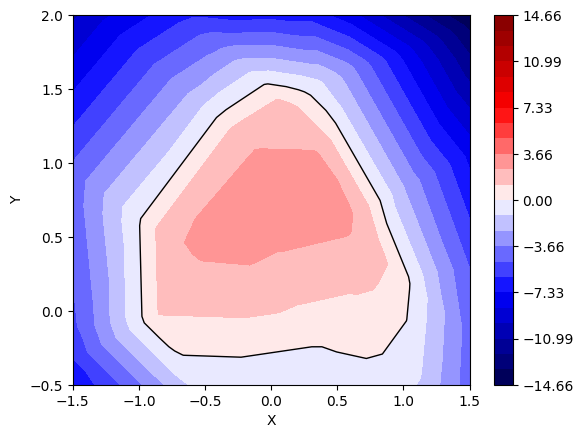

Overall Training Progress:  40%|████      | 600/1500 [47:24<1:10:54,  4.73s/it, Training Accuracy=0.995, Validation1 Accuracy=0.979, Validation001 Accuracy=0.558, Validation002 Accuracy=0.568, Validation003 Accuracy=0.664, Validation004 Accuracy=0.707, Validation005 Accuracy=0.704, Validation010 Accuracy=0.824]

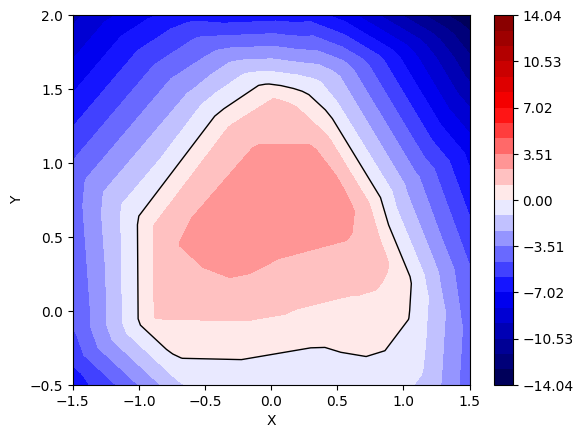

Overall Training Progress:  60%|██████    | 900/1500 [1:11:03<47:19,  4.73s/it, Training Accuracy=0.99, Validation1 Accuracy=0.982, Validation001 Accuracy=0.587, Validation002 Accuracy=0.605, Validation003 Accuracy=0.702, Validation004 Accuracy=0.745, Validation005 Accuracy=0.737, Validation010 Accuracy=0.828] 

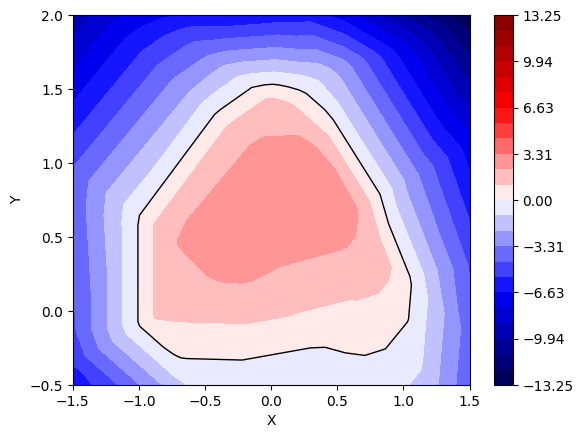

Overall Training Progress:  80%|████████  | 1200/1500 [1:34:43<23:31,  4.71s/it, Training Accuracy=0.995, Validation1 Accuracy=0.982, Validation001 Accuracy=0.6, Validation002 Accuracy=0.615, Validation003 Accuracy=0.71, Validation004 Accuracy=0.754, Validation005 Accuracy=0.733, Validation010 Accuracy=0.829]   

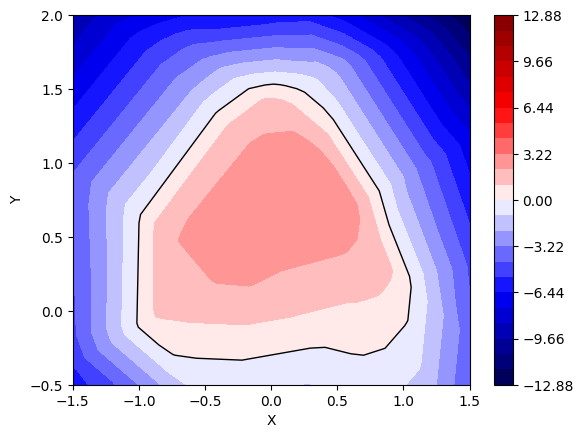

Overall Training Progress: 100%|██████████| 1500/1500 [1:58:29<00:00,  4.83s/it, Training Accuracy=0.995, Validation1 Accuracy=0.981, Validation001 Accuracy=0.587, Validation002 Accuracy=0.604, Validation003 Accuracy=0.704, Validation004 Accuracy=0.754, Validation005 Accuracy=0.73, Validation010 Accuracy=0.838] 

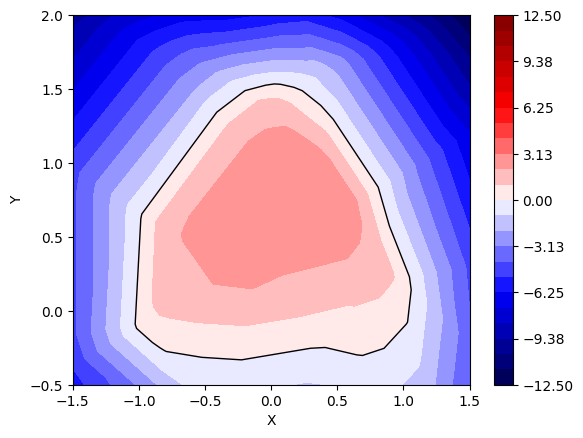

Overall Training Progress: 100%|██████████| 1500/1500 [1:58:30<00:00,  4.74s/it, Training Accuracy=0.995, Validation1 Accuracy=0.981, Validation001 Accuracy=0.587, Validation002 Accuracy=0.604, Validation003 Accuracy=0.704, Validation004 Accuracy=0.754, Validation005 Accuracy=0.73, Validation010 Accuracy=0.838]


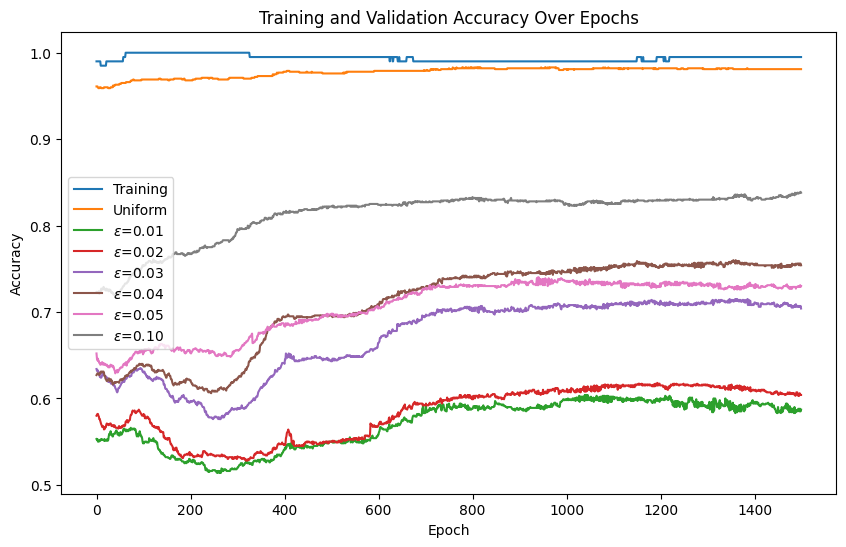

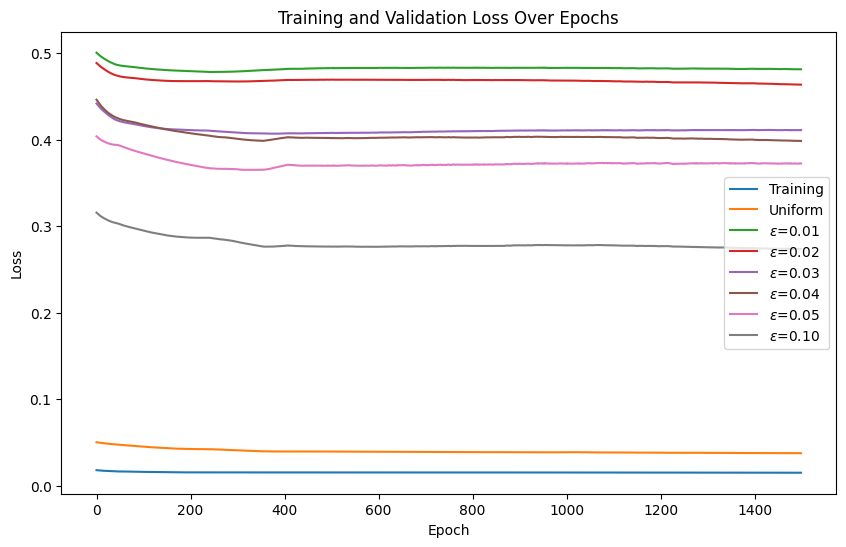

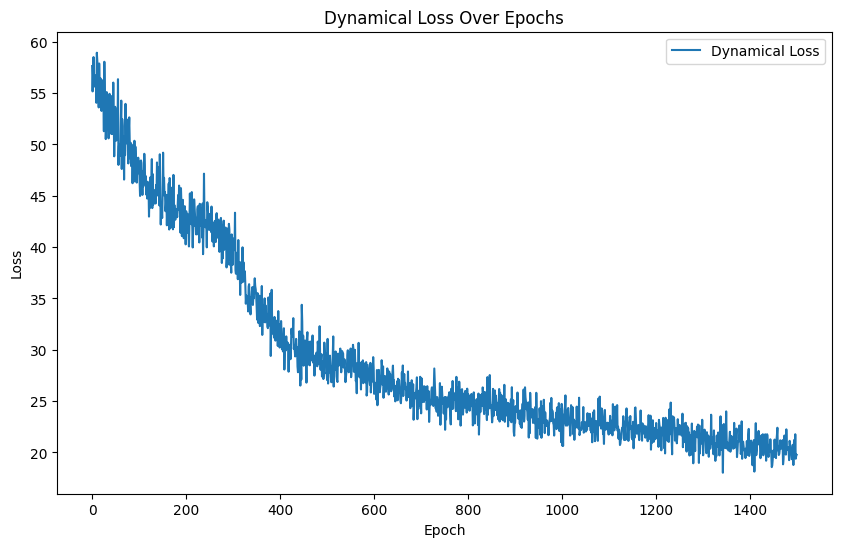

In [446]:
dataset_train_copy = deepcopy(dataset_train)
net_5 = deepcopy(net_hinge_square)
train_model_dynamical_adaptive(net_5, dataset_train_copy, dataset_validation_uniform, dataset_validation_near_001, dataset_validation_near_002, dataset_validation_near_003,
                    dataset_validation_near_004, dataset_validation_near_005, dataset_validation_near_010, batchsize=len(dataset_train_copy), epochs=1500, lr=5e-5)

Accuracy: 0.9810000061988831


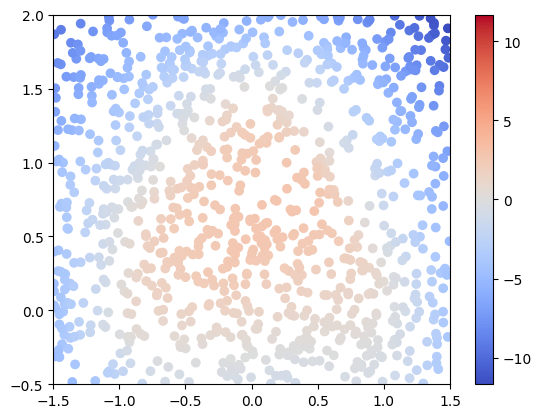

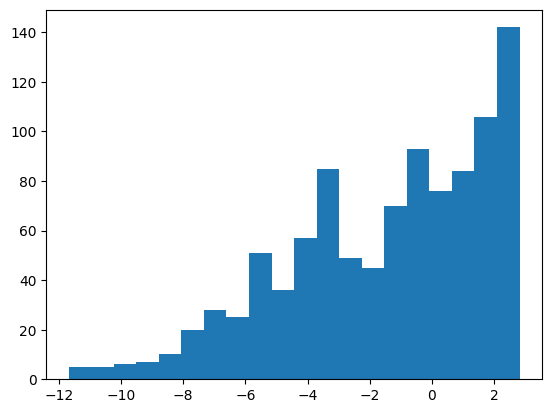

tensor(0.9810)

In [447]:
test_model(net_5, dataset_test_uniform)

Accuracy: 0.6010000109672546


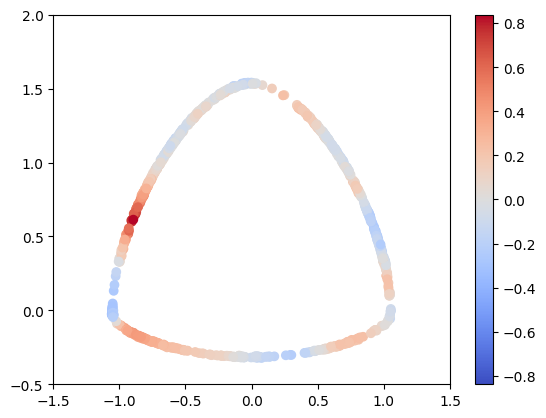

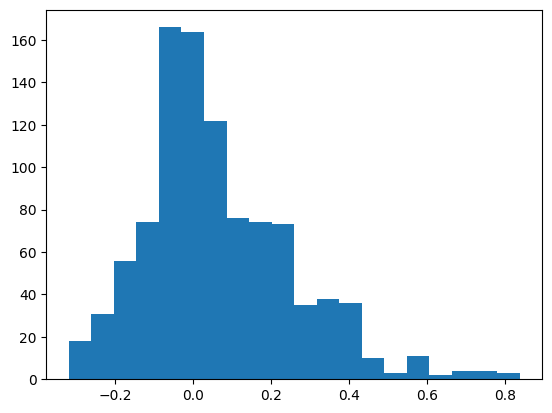

tensor(0.6010)

In [448]:
test_model(net_5, dataset_test_near_001)

Accuracy: 0.6470000147819519


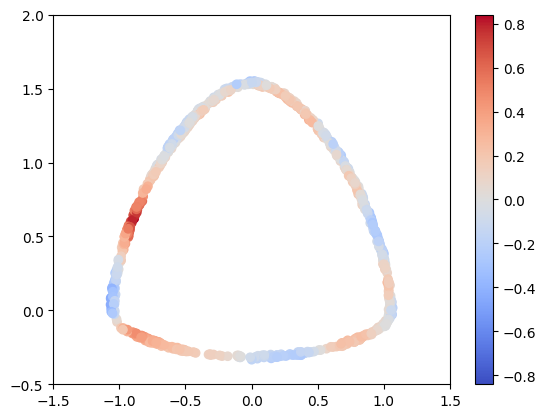

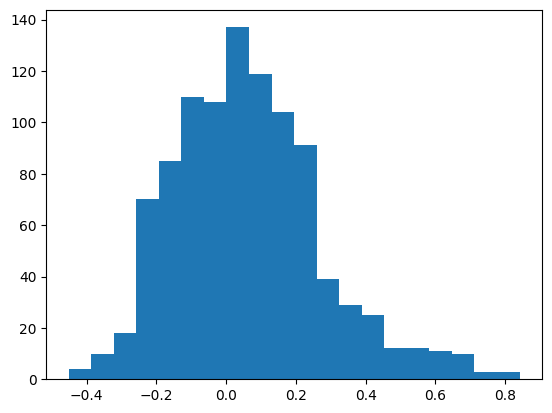

tensor(0.6470)

In [449]:
test_model(net_5, dataset_test_near_002)

Accuracy: 0.7070000171661377


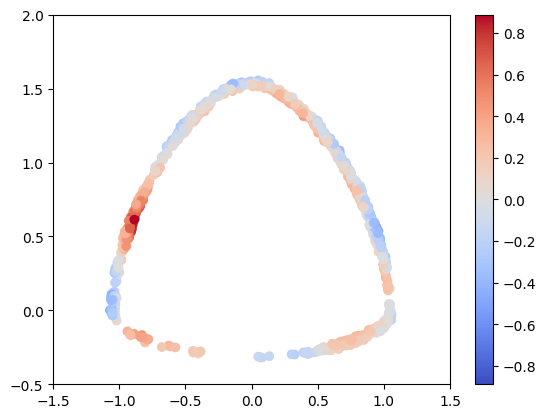

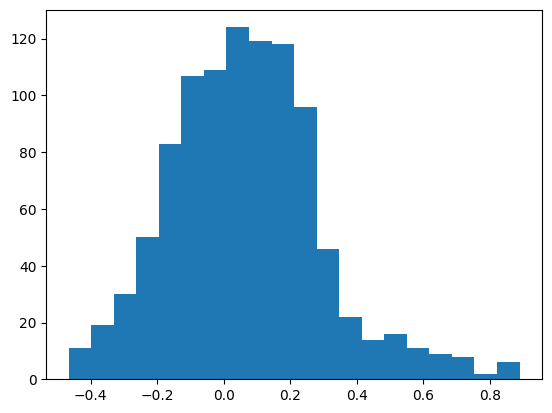

tensor(0.7070)

In [450]:
test_model(net_5, dataset_test_near_003)

Accuracy: 0.753000020980835


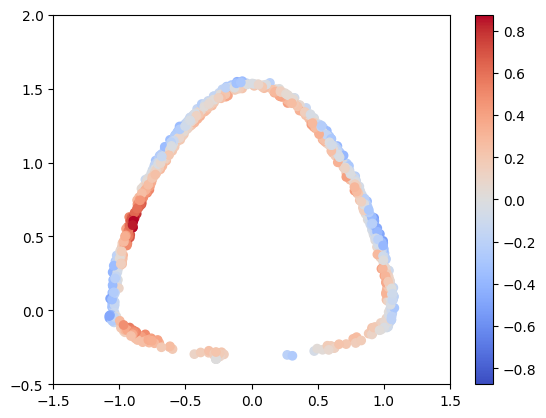

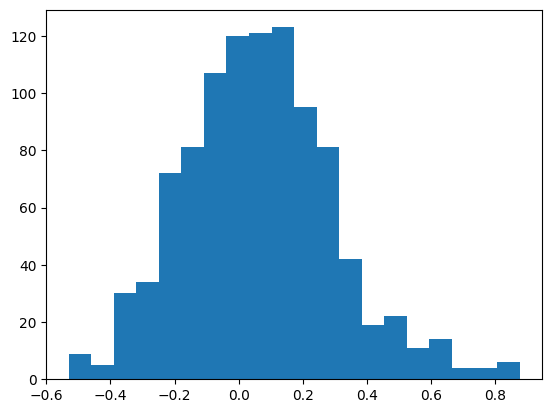

tensor(0.7530)

In [451]:
test_model(net_5, dataset_test_near_004)

Accuracy: 0.718999981880188


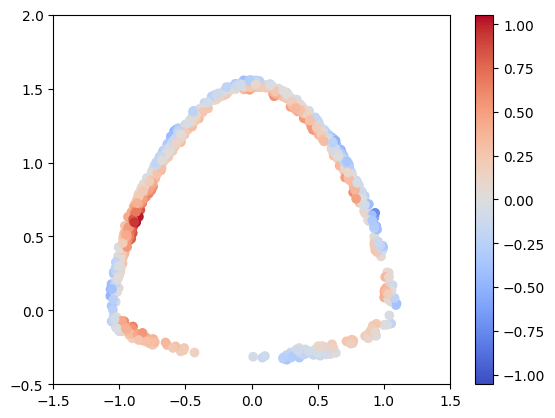

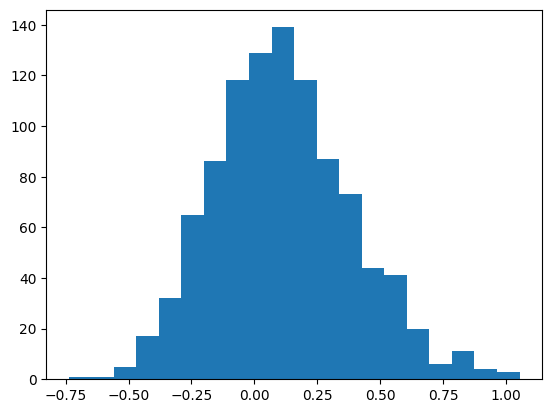

tensor(0.7190)

In [452]:
test_model(net_5, dataset_test_near_005)

Accuracy: 0.824999988079071


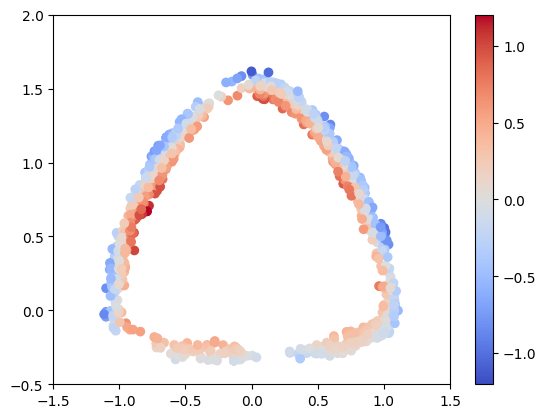

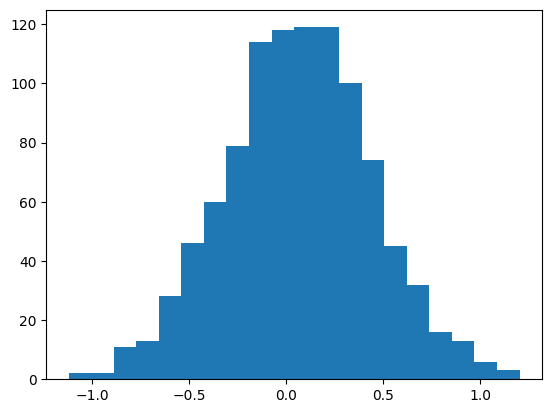

tensor(0.8250)

In [453]:
test_model(net_5, dataset_test_near_010)

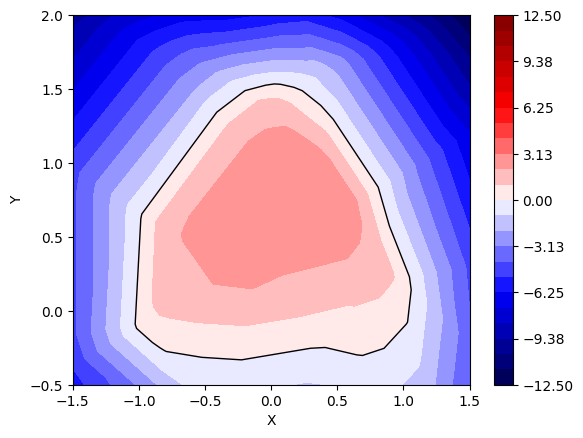

In [454]:
plot_contour(net_5)

Overall Training Progress: 100%|██████████| 10000/10000 [12:53:40<00:00,  4.64s/it, Training Accuracy=1, Validation1 Accuracy=0.981, Validation001 Accuracy=0.528, Validation002 Accuracy=0.552, Validation003 Accuracy=0.624, Validation004 Accuracy=0.637, Validation005 Accuracy=0.628, Validation010 Accuracy=0.767]     


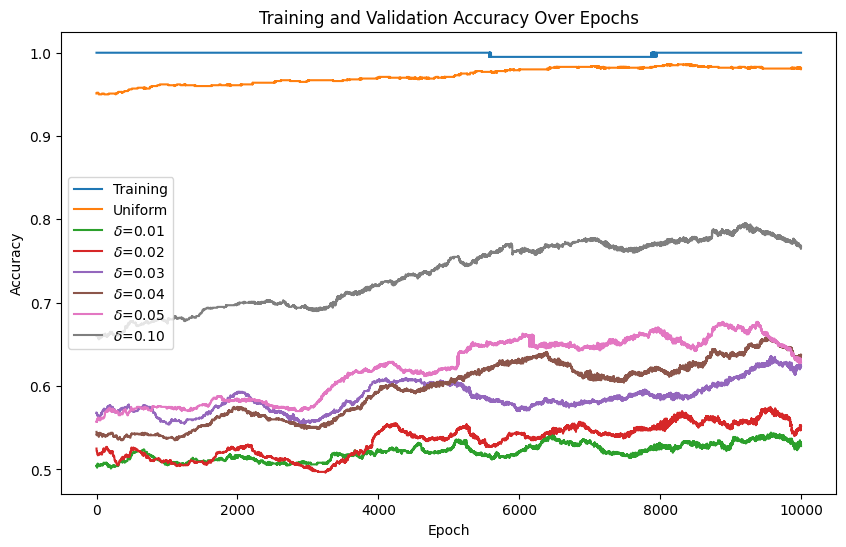

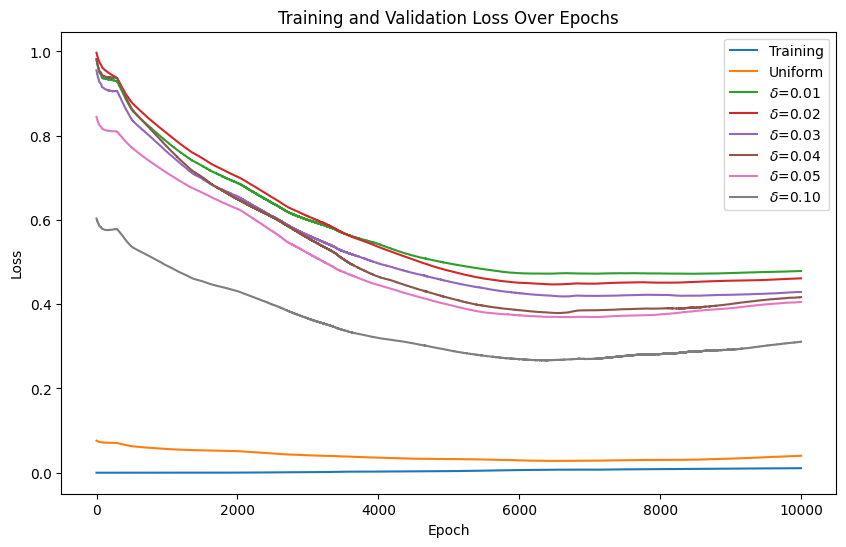

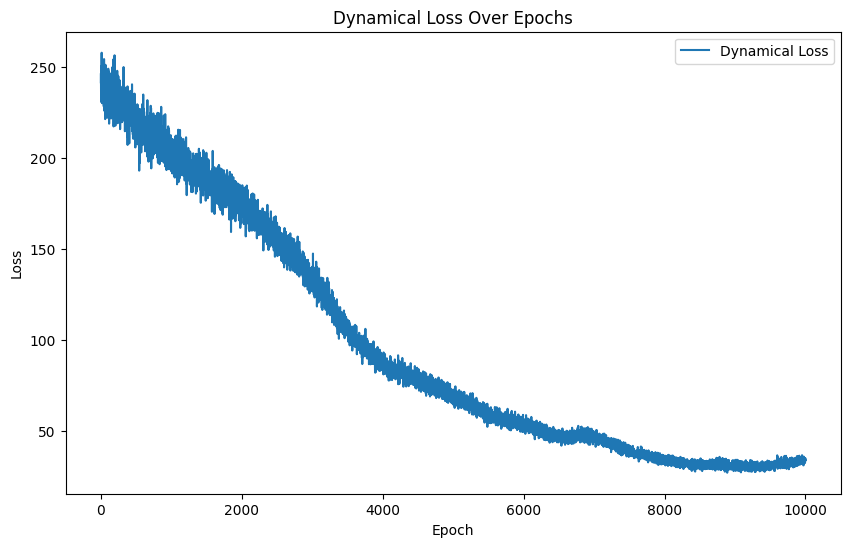

Accuracy: 1.0


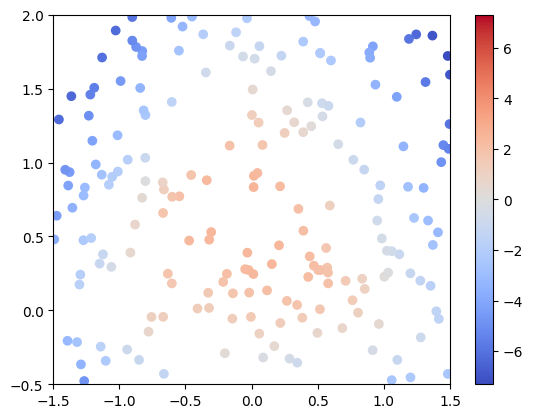

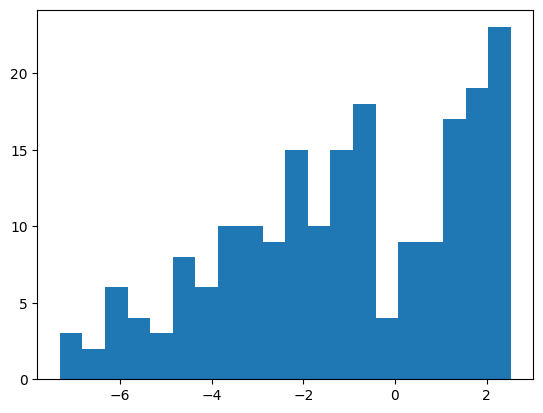

Accuracy: 0.9810000061988831


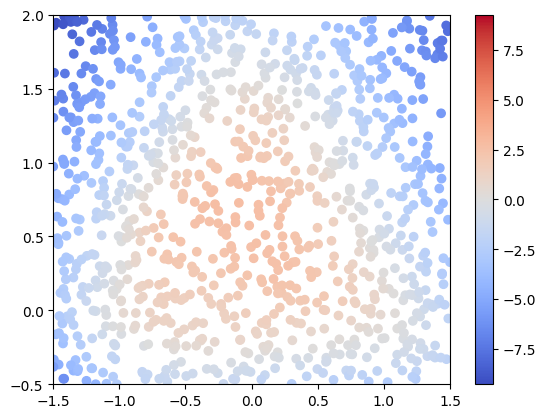

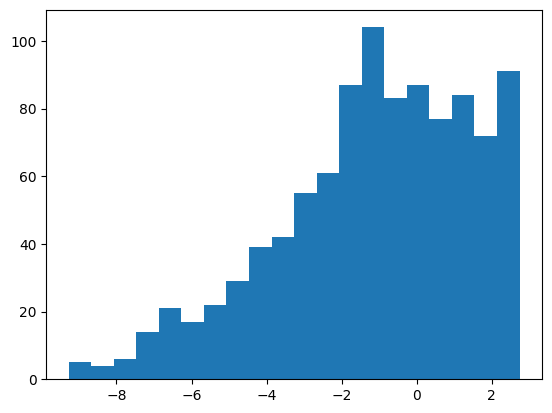

Accuracy: 0.527999997138977


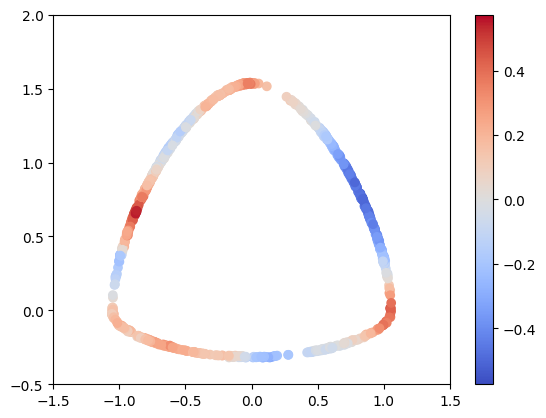

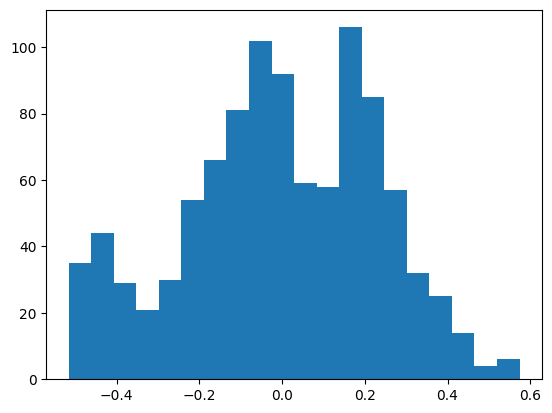

Accuracy: 0.5519999861717224


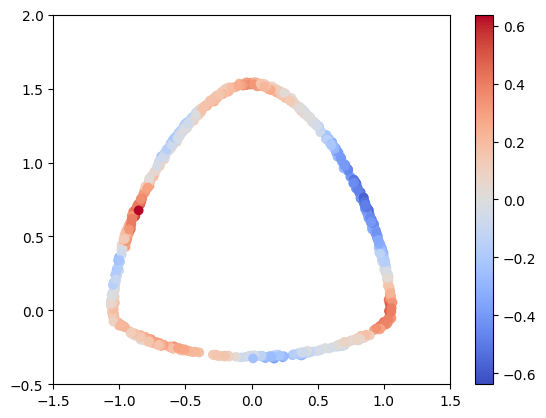

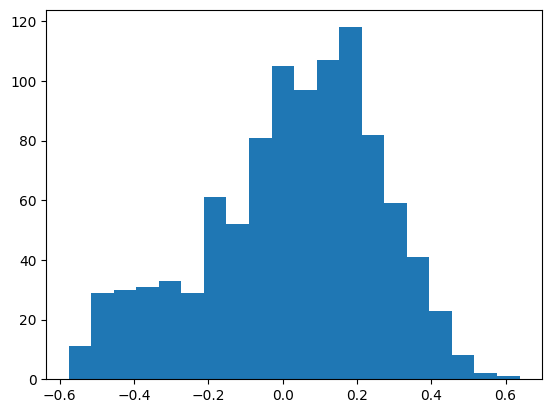

Accuracy: 0.6240000128746033


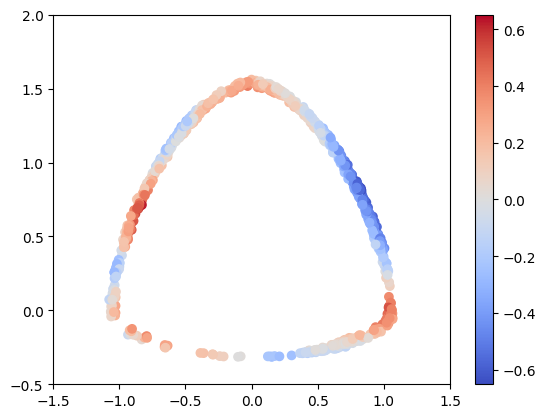

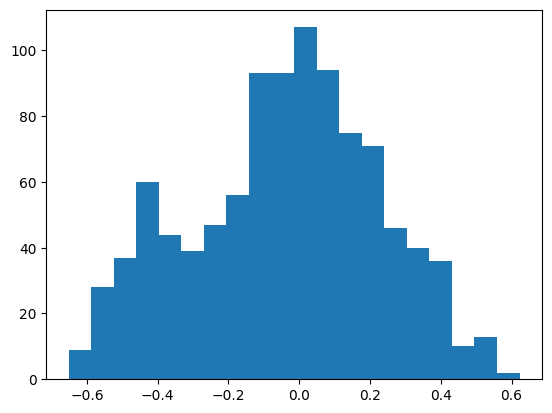

Accuracy: 0.6370000243186951


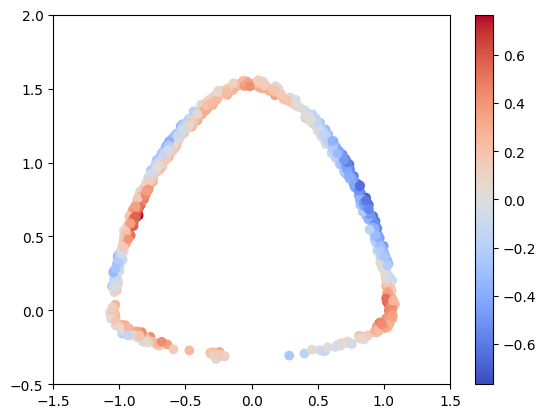

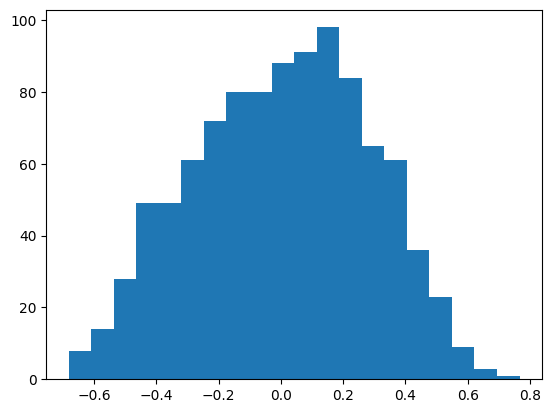

Accuracy: 0.628000020980835


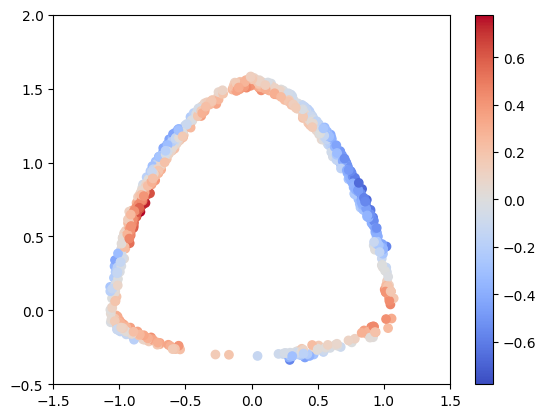

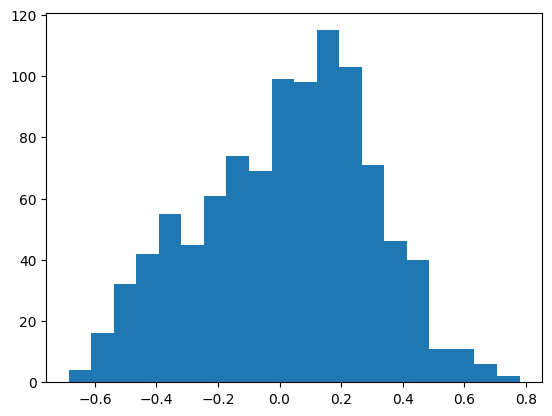

Accuracy: 0.7670000195503235


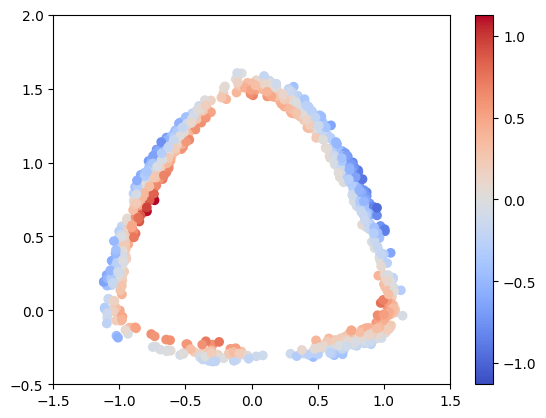

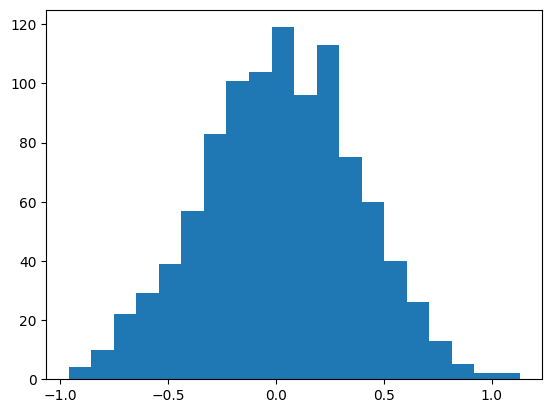

In [355]:
dataset_train_copy = deepcopy(dataset_train)
net_6 = deepcopy(net_hinge)
train_model_dynamical_adaptive(net_6, dataset_train_copy, dataset_validation_uniform, dataset_validation_near_001, dataset_validation_near_002, dataset_validation_near_003,
                    dataset_validation_near_004, dataset_validation_near_005, dataset_validation_near_010, batchsize=len(dataset_train_copy), epochs=10000, lr=5e-5)

Accuracy: 0.984000027179718


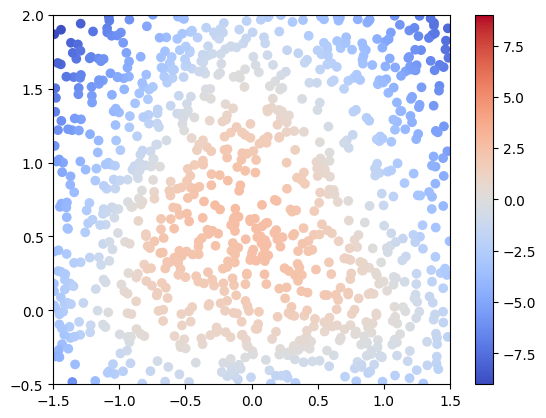

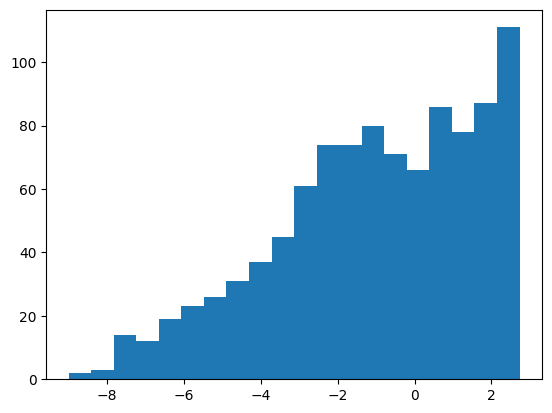

tensor(0.9840)

In [356]:
test_model(net_6, dataset_test_uniform)

Accuracy: 0.5270000100135803


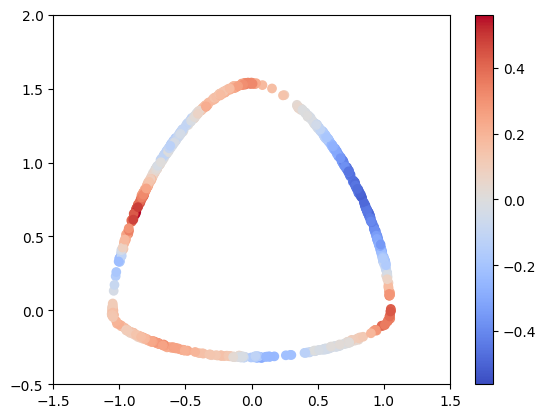

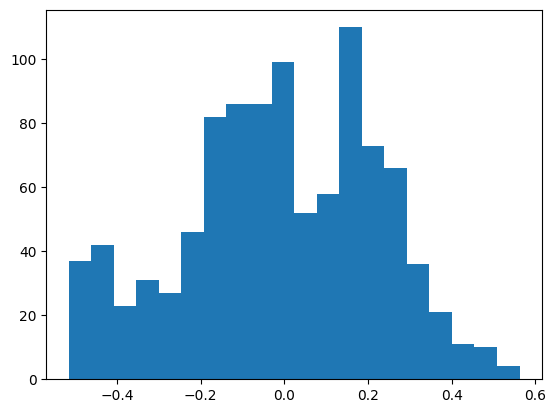

tensor(0.5270)

In [357]:
test_model(net_6, dataset_test_near_001)

Accuracy: 0.593999981880188


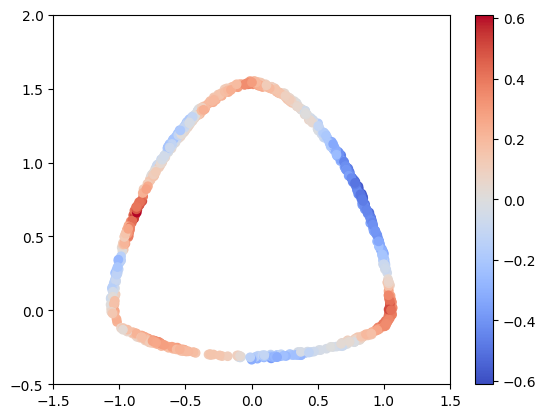

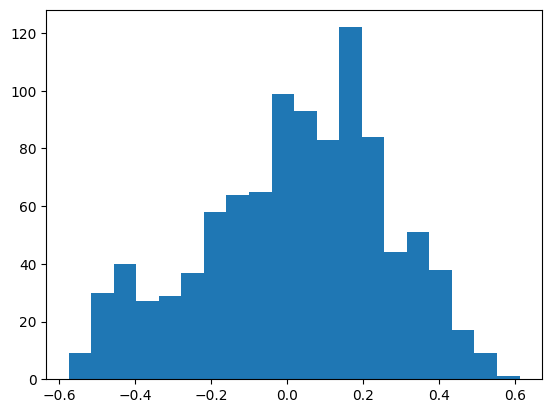

tensor(0.5940)

In [358]:
test_model(net_6, dataset_test_near_002)

Accuracy: 0.609000027179718


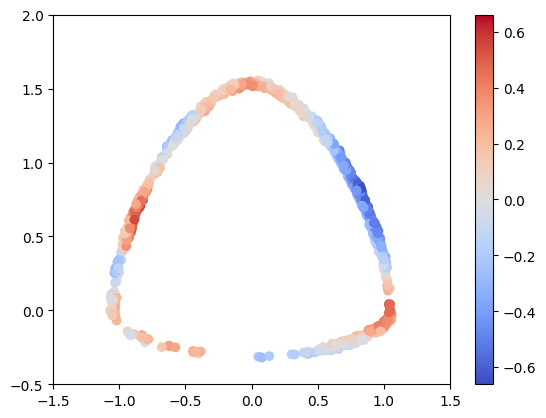

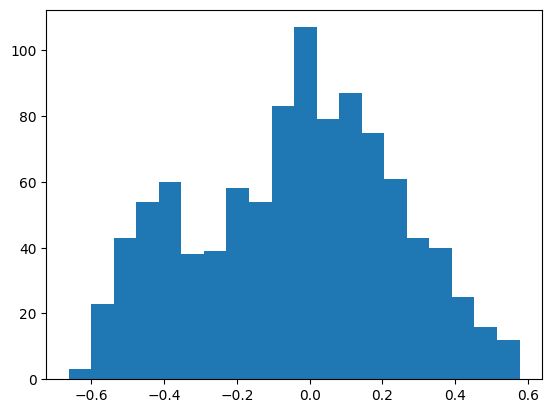

tensor(0.6090)

In [359]:
test_model(net_6, dataset_test_near_003)

Accuracy: 0.6520000100135803


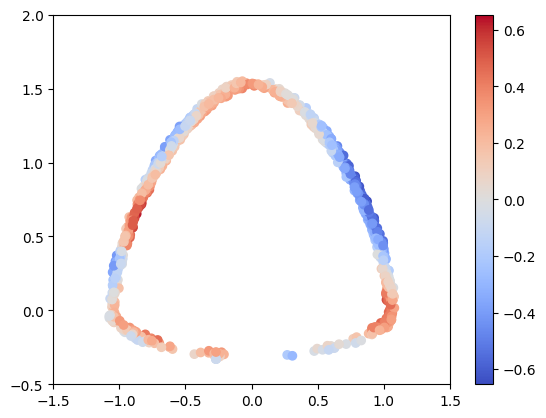

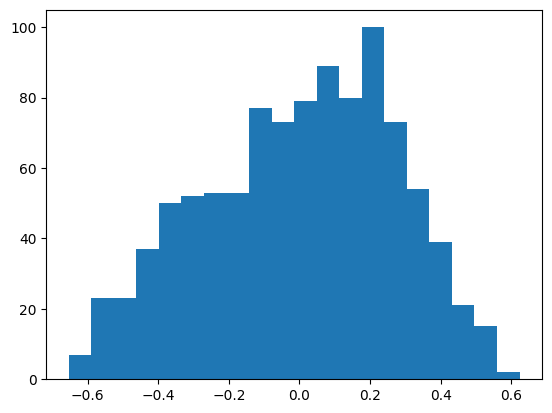

tensor(0.6520)

In [360]:
test_model(net_6, dataset_test_near_004)

Accuracy: 0.6430000066757202


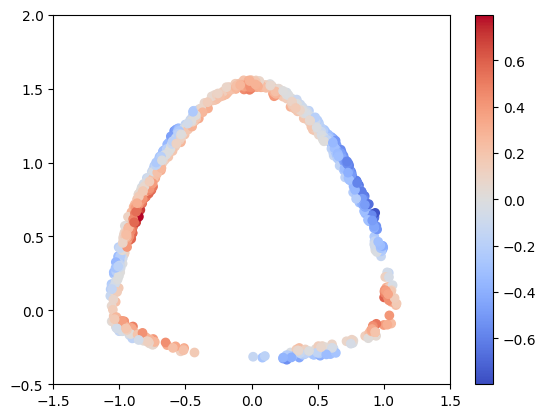

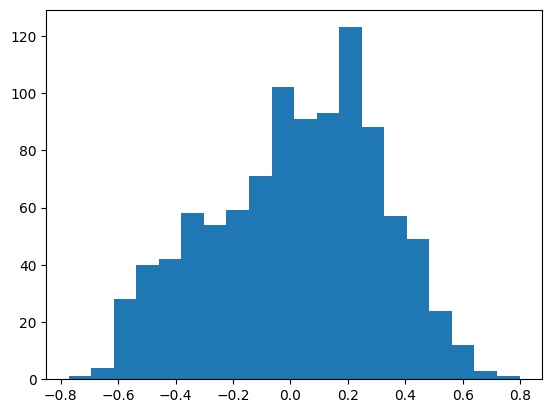

tensor(0.6430)

In [361]:
test_model(net_6, dataset_test_near_005)

Accuracy: 0.7919999957084656


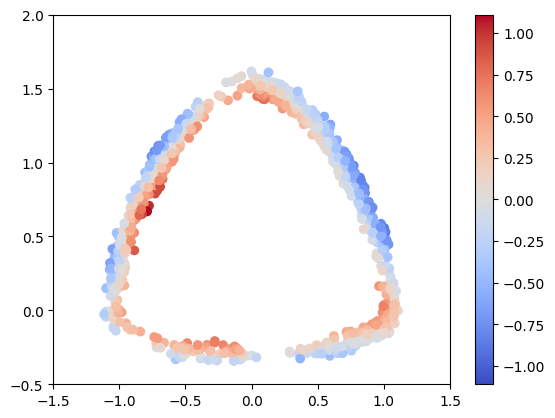

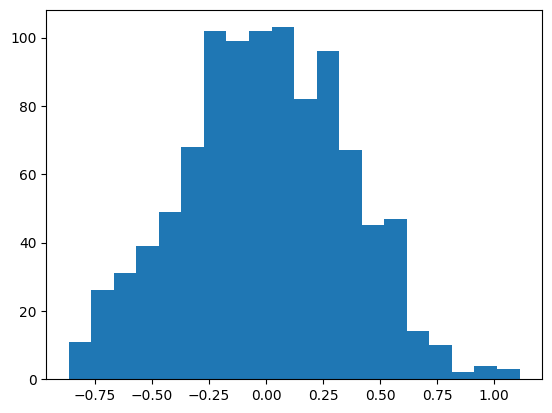

tensor(0.7920)

In [362]:
test_model(net_6, dataset_test_near_010)

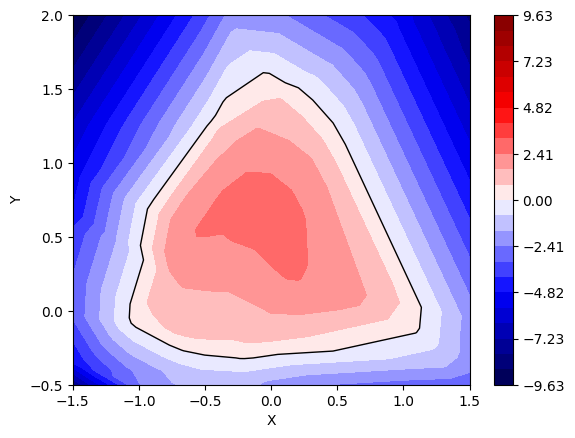

In [363]:
plot_contour(net_6)